# Exercise 1

In [1]:
# Importing libraries
library(tidyverse)
library(geosphere)
library(ggokabeito) # Colorblind-friendly patterns for ex2 ratio graph

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## 1-2-3

In [2]:
# 1) Create a list of tibbles from saved files in dir 'data/'
tmp <- list()
for (i in list.files('data/')) {tmp[[i]] <- read_csv(paste("data/", i, sep=''))}

# 2-3) Bind all the tibbles together, and remove rows with na values (I did not actually find any NA value)
data.bike <- bind_rows(tmp) |> drop_na()

Rows: 18565 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (3): start station name, end station name, usertype
dbl  (10): tripduration, start station id, start station latitude, start sta...
dttm  (2): starttime, stoptime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 23606 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (3): start station name, end station name, usertype
dbl  (10): tripduration, start station id, start station latitude, start sta...
dttm  (2): starttime, stoptime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 33056 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimit

## 4

In [3]:
# 4) Trip duration information

trip_info <- function(col){cat("Trip Duration info\nMean:", mean(col), "min\nMedian:", median(col), "min\nMax:", max(col), "min\nMin:", min(col), "min\n")} 

data.bike$trip.min <- data.bike$tripduration / 60
less.data.bike <- filter(data.bike, data.bike$trip.min < 180)

cat('Whole dataframe\n')
trip_info(data.bike$trip.min)

cat('\nFiltered dataframe\n')
trip_info(less.data.bike$trip.min)

cat('\nNumber of skimmed entries:', dim(data.bike)[[1]] - dim(less.data.bike)[[1]])

Whole dataframe
Trip Duration info
Mean: 12.81071 min
Median: 5.683333 min
Max: 28817 min
Min: 1.016667 min

Filtered dataframe
Trip Duration info
Mean: 9.221901 min
Median: 5.666667 min
Max: 179.9667 min
Min: 1.016667 min

Number of skimmed entries: 428

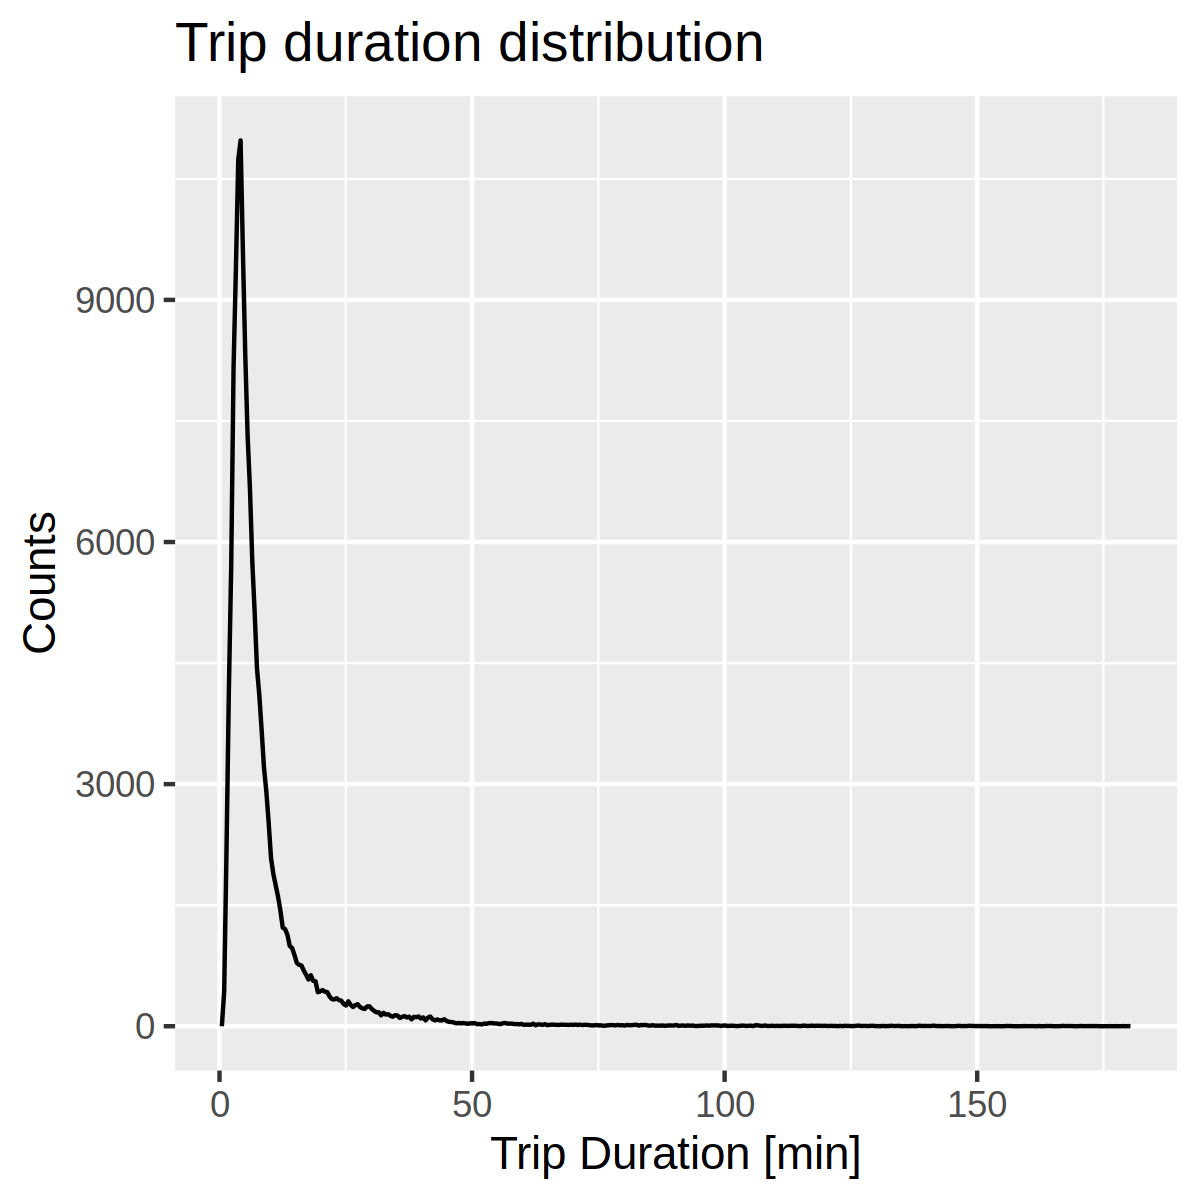

In [4]:
# Distribution plot
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300)
ggplot(data=less.data.bike, mapping=aes(trip.min)) + geom_freqpoly(bins=as.integer(sqrt(dim(less.data.bike)[[1]]))) + labs(x='Trip Duration [min]', y='Counts', title='Trip duration distribution')

## 5

In [5]:
# Depending on R settings the language of the labels may vary, one could explicitly use Sys.setlocale(LC_TIME, "en_US.UTF-8"), if the English language is installed
less.data.bike$month <- month(less.data.bike$starttime, label=T)
less.data.bike$week <- week(less.data.bike$starttime)

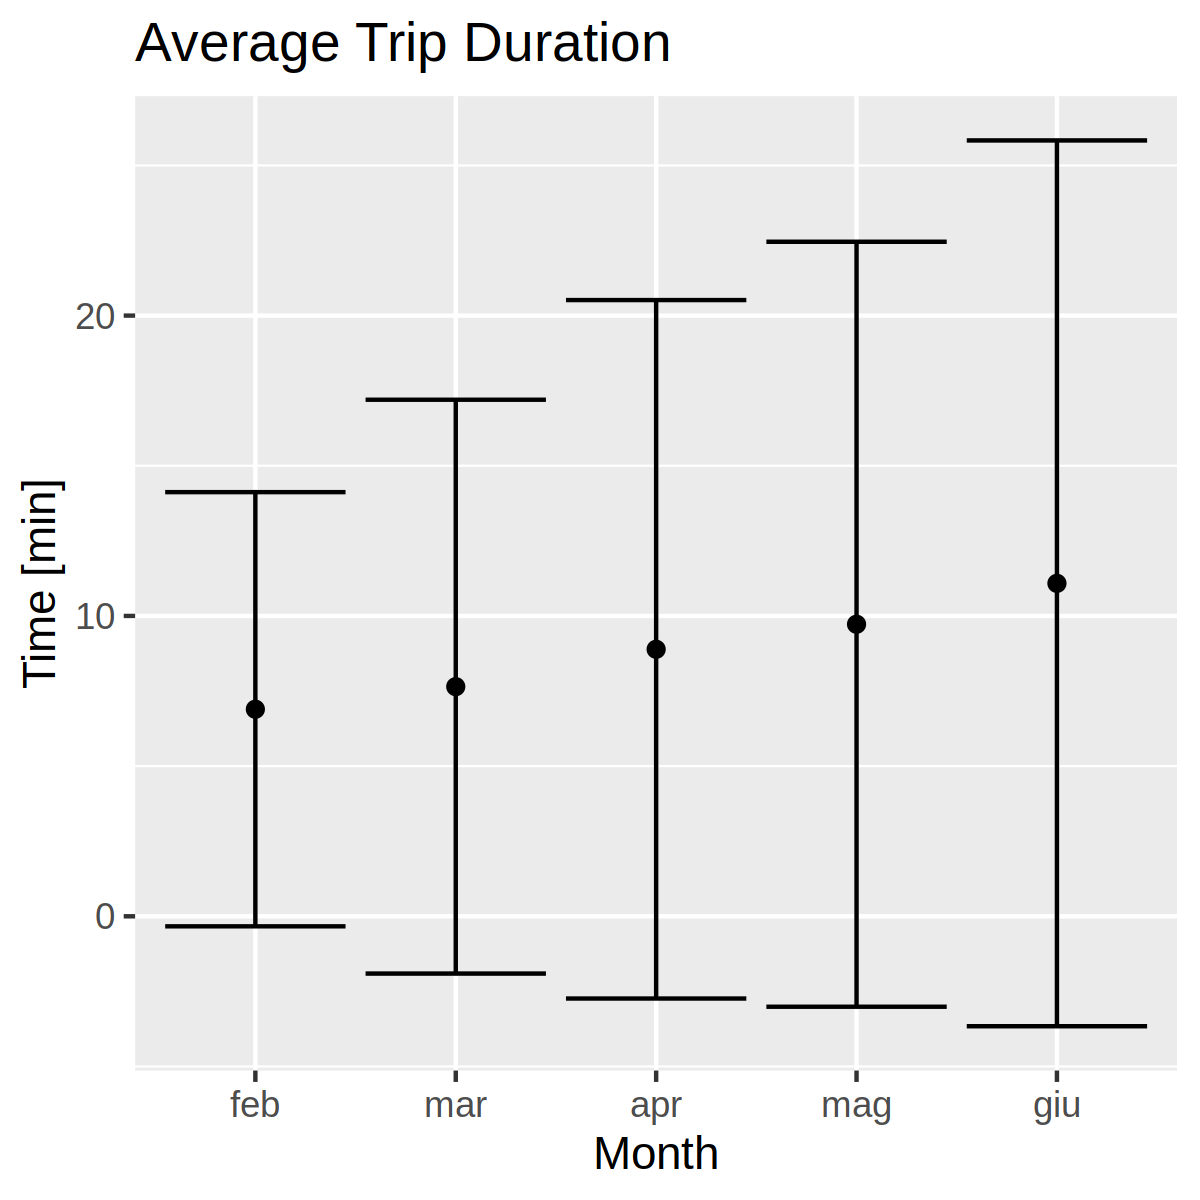

In [6]:
data.plot <- less.data.bike |> group_by(month) |> summarize(mean=mean(trip.min), sd=sd(trip.min))
ggplot(data.plot, mapping=aes(x=month, y=mean, ymin=mean - sd, ymax=mean + sd)) + 
geom_point() + geom_errorbar() + labs(x='Month', y='Time [min]', title='Average Trip Duration')

## 6

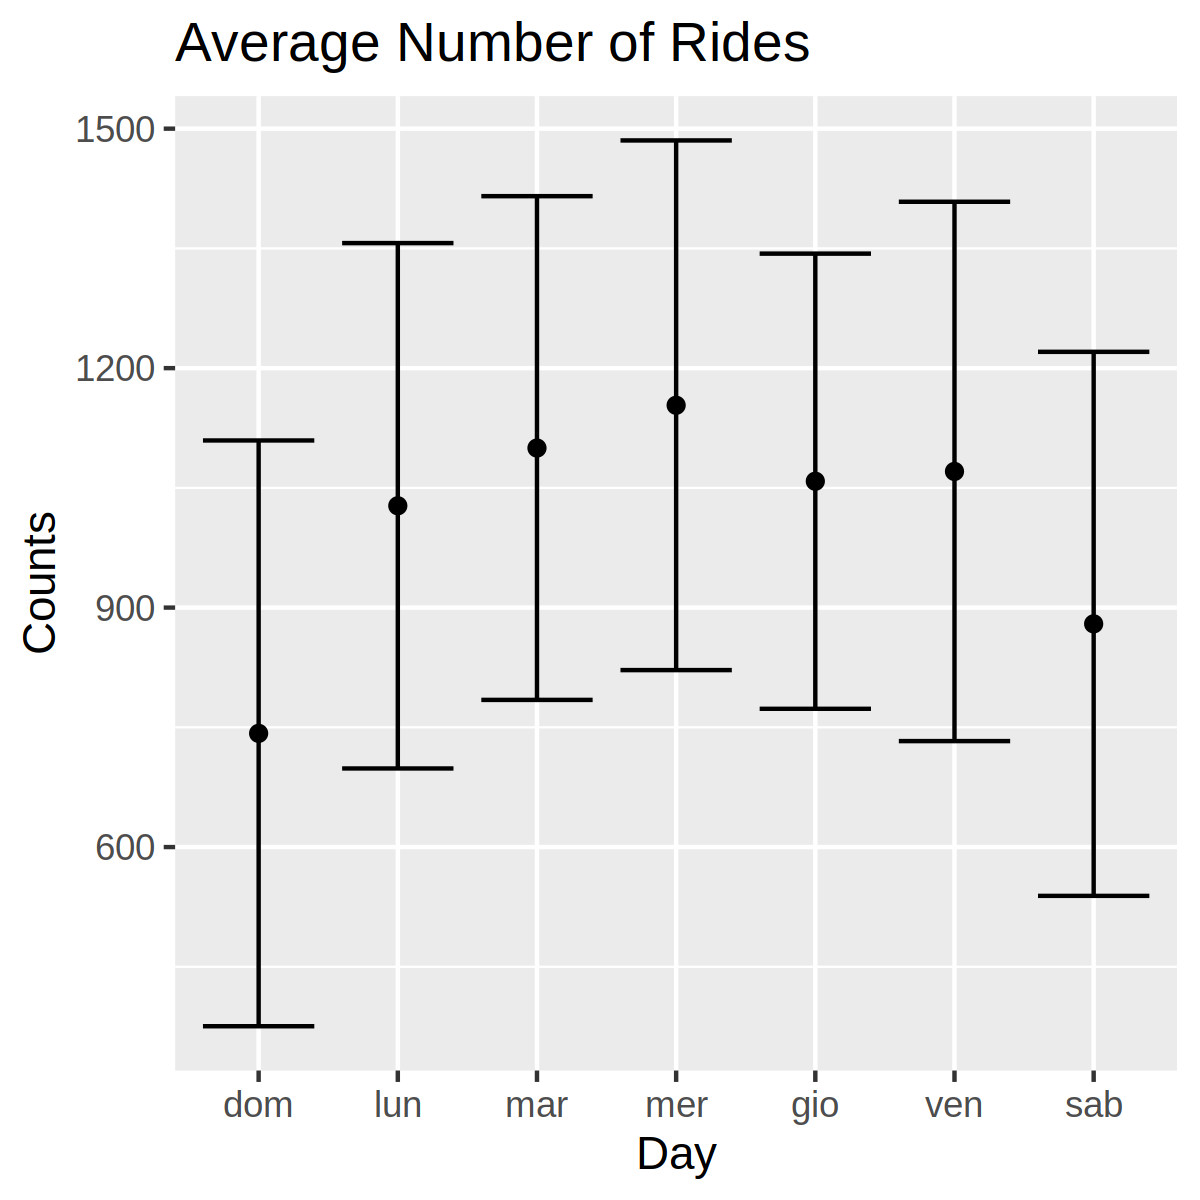

In [7]:
# 6.1
data.plot <- less.data.bike |> group_by(week, wday=wday(starttime, label=T)) |> count() |> group_by(wday) |> summarise(mean=mean(n), std=sd(n))
ggplot(data.plot, mapping=aes(x=wday, y=mean, ymin=mean - std, ymax=mean + std)) + geom_point() + geom_errorbar(width=.8) + labs(x='Day', y='Counts', title='Average Number of Rides')

In [8]:
less.data.bike <- less.data.bike |> mutate(weekend=if_else(wday(starttime) %in% c(1,7), 'Weekend', 'Weekdays'))

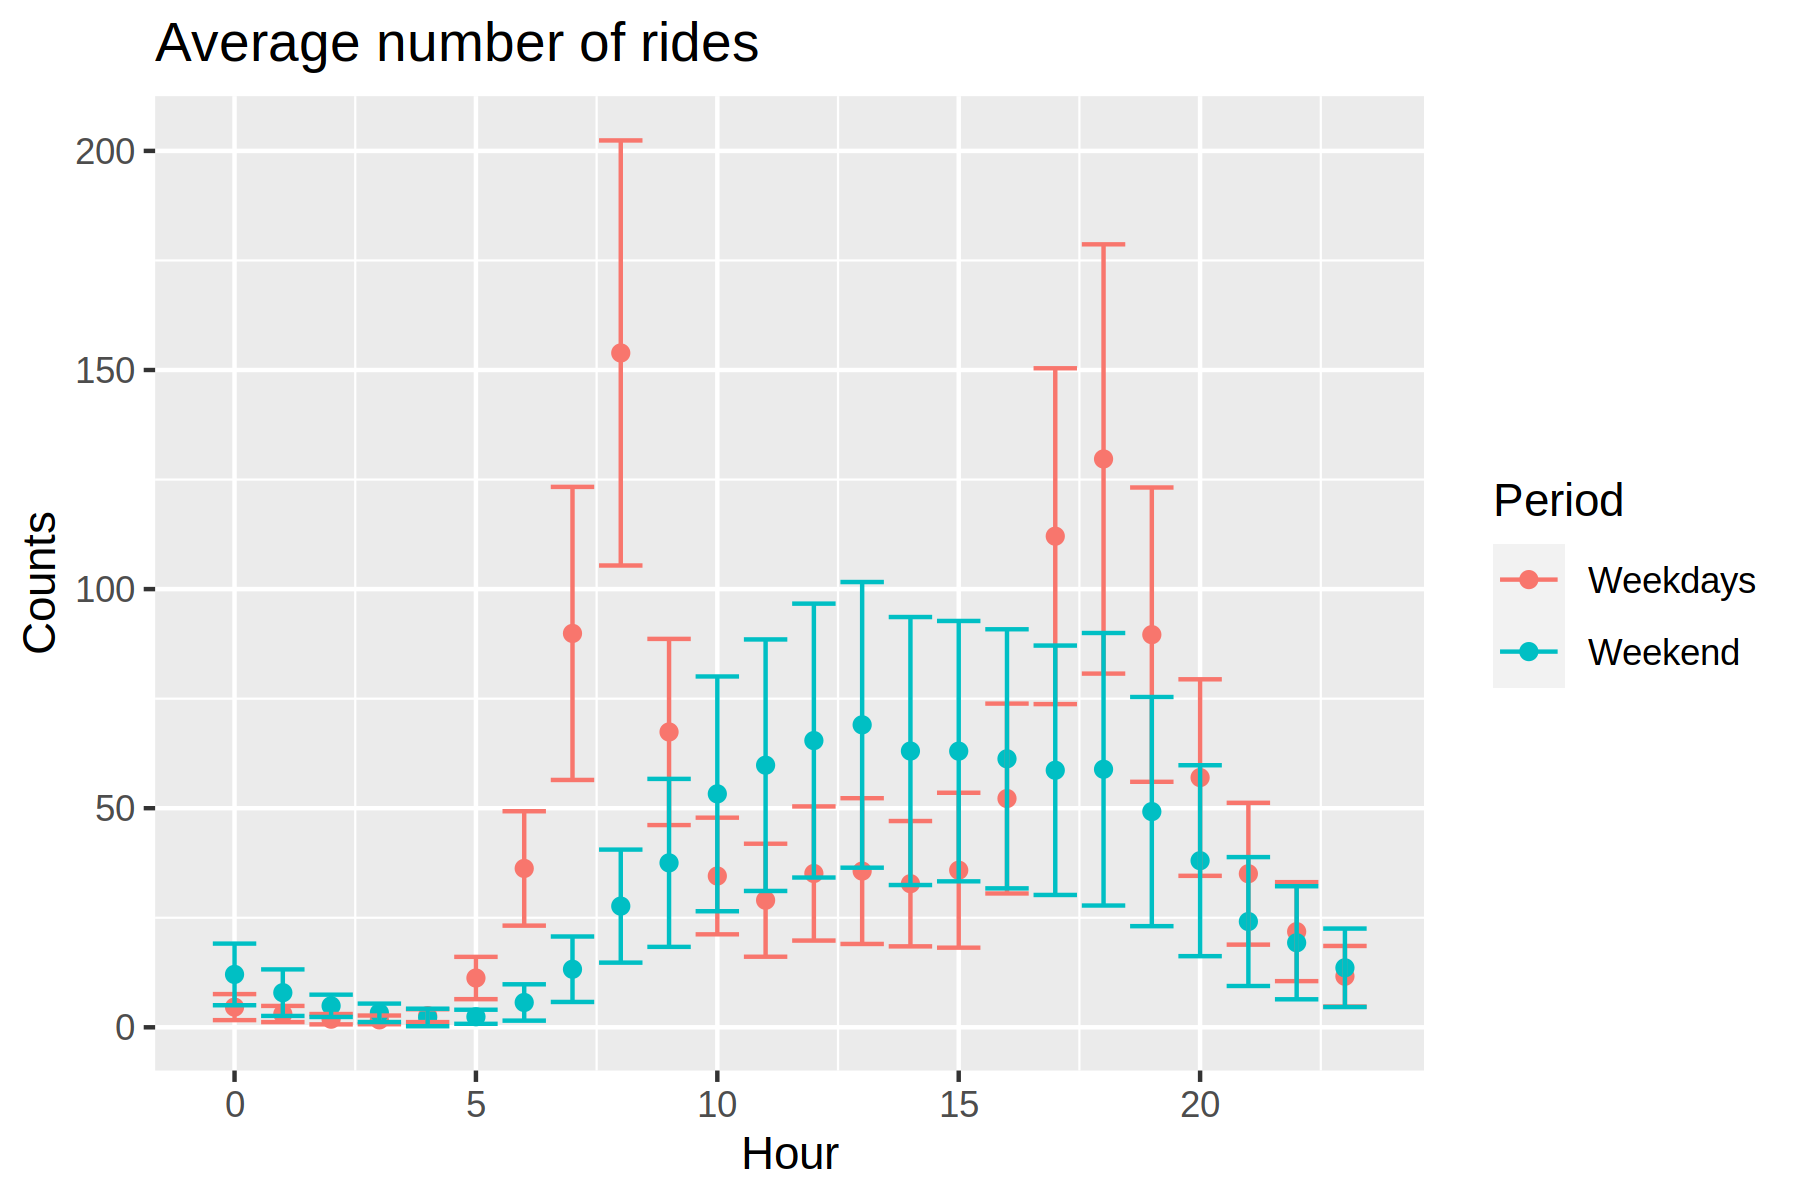

In [9]:
# 6.2
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 300)
data.plot <- less.data.bike |> group_by(weekend, week, wday(starttime), hour=hour(starttime)) |> count() |> group_by(weekend,hour) |> summarise(mean=mean(n), std=sd(n), .groups='drop')
ggplot(data.plot, mapping=aes(x=hour, y=mean, ymin=mean - std, ymax=mean + std, color=weekend)) + geom_point() + geom_errorbar() + labs(x='Hour', y='Counts', title='Average number of rides', color='Period')

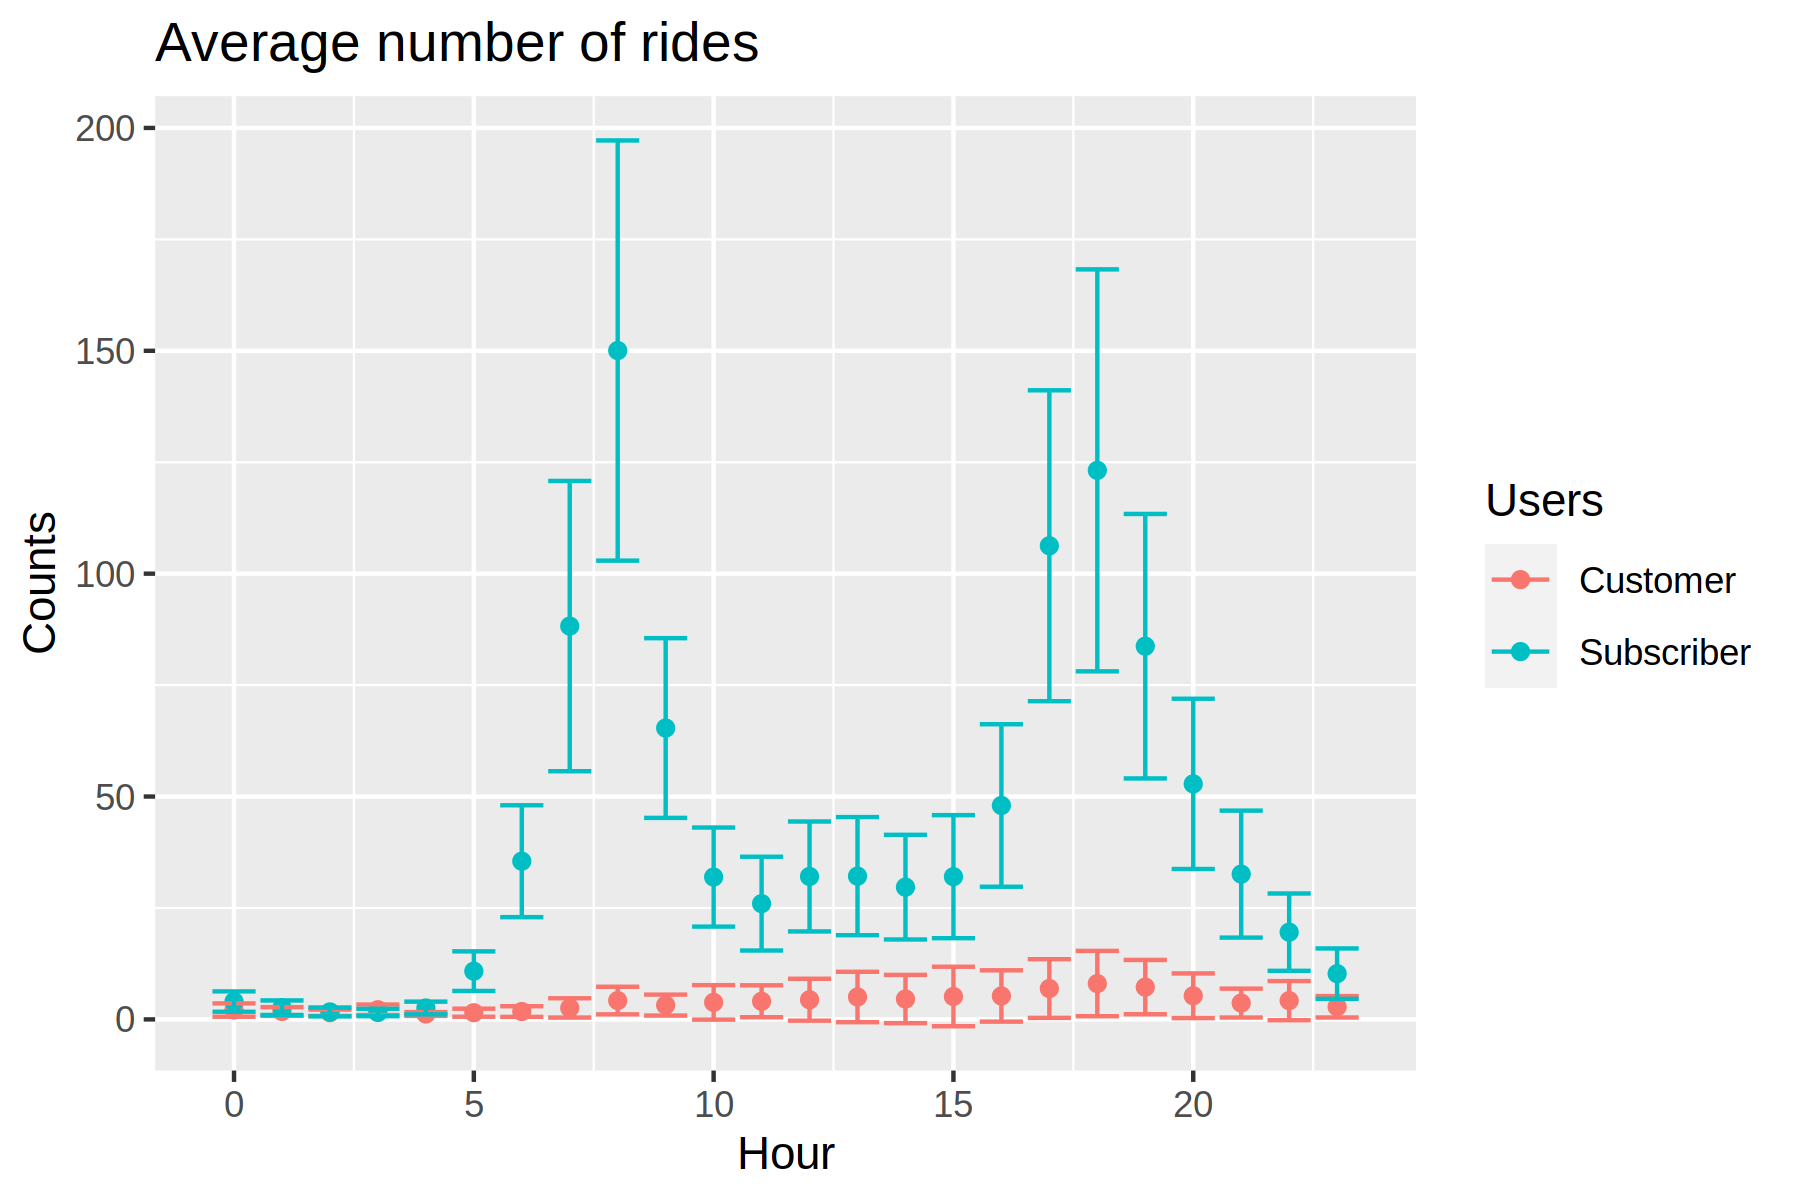

In [10]:
# 6.3
data.plot <- filter(less.data.bike, weekend=='Weekdays') |> group_by(usertype, week, wday=wday(starttime, label=T), hour=hour(starttime)) |> count() |> group_by(usertype, hour) |> summarise(mean=mean(n), std=sd(n), .groups='drop')
ggplot(data.plot, mapping=aes(x=hour, y=mean, ymin=mean - std, ymax=mean + std, color=usertype)) + geom_point() + geom_errorbar() + labs(x='Hour', y='Counts', title='Average number of rides', color='Users')

## 7

In [11]:
lesser.data.bike <- less.data.bike |> filter(tripduration <= 3600) |> mutate(distance=distHaversine(bind_cols(`start station longitude`, `start station latitude`), bind_cols(`end station longitude`, `end station latitude`)), speed=distance / tripduration * 3.6, dist.group=cut(distance, c(0, 500, 1000, 2000, 3000, Inf)))

New names:
• `` -> `...1`
• `` -> `...2`
New names:
• `` -> `...1`
• `` -> `...2`


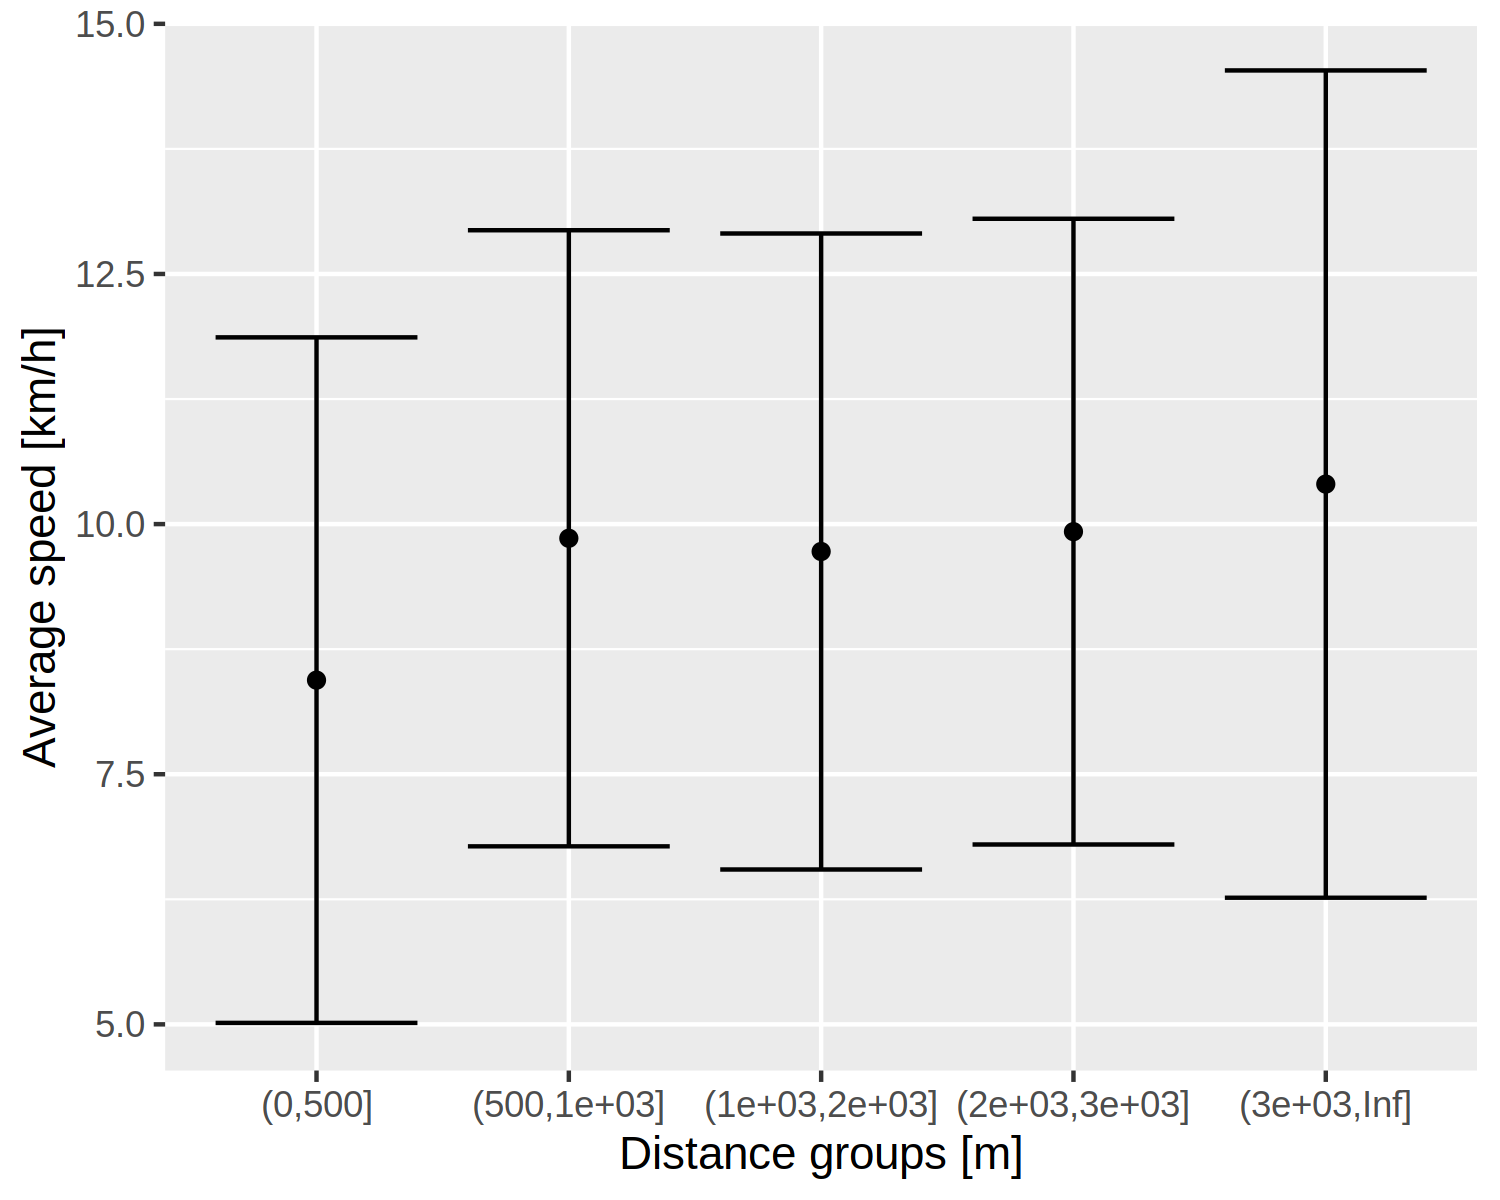

In [12]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 300)

# Excluding trips with same start and end station, since they would have 0 km/h average speed
data.plot <- lesser.data.bike |> filter(`start station name` != `end station name`) |> group_by(dist.group) |> summarise(mean=mean(speed), sd=sd(speed))
ggplot(data.plot, aes(x=dist.group, y=mean, ymin=mean - sd, ymax=mean + sd)) + geom_point() + geom_errorbar(width=.8) + labs(x='Distance groups [m]', y='Average speed [km/h]')

## 8
(**N.B:** there are 14 least popular end station with no tiebreaker criterion, which are simply shown together. This cannot be done when finding k-least routes, as there are hundreds of ties for counts of 1, 2, and 3.)

In [13]:
start.class <- less.data.bike |> group_by(`start station name`) |> count() |> arrange(desc(n))
end.class <- less.data.bike |> group_by(`end station name`) |> count() |> arrange(desc(n))
print(filter(start.class, n == start.class$n[[1]]))
print(filter(end.class, n == end.class$n[[dim(end.class)[[1]] ]]))

# A tibble: 1 × 2
# Groups:   start station name [1]
  `start station name`     n
  <chr>                <int>
1 Grove St PATH        17871
# A tibble: 14 × 2
# Groups:   end station name [14]
   `end station name`           n
   <chr>                    <int>
 1 1 Ave & E 16 St              1
 2 8 Ave & W 52 St              1
 3 E 33 St & 5 Ave              1
 4 Norfolk St & Broome St       1
 5 South St & Gouverneur Ln     1
 6 Spruce St & Nassau St        1
 7 W 15 St & 10 Ave             1
 8 W 15 St & 6 Ave              1
 9 W 20 St & 11 Ave             1
10 W 27 St & 10 Ave             1
11 W 38 St & 8 Ave              1
12 W 43 St & 6 Ave              1
13 W 56 St & 10 Ave             1
14 West St & Chambers St        1


In [14]:
route <- less.data.bike |> group_by(`start station name`, `end station name`) |> count() |> arrange(desc(n))
print(route[1:3,])
print(route[( (dim(route)[[1]] -> route.dim1) - 2 ) : route.dim1,])

# A tibble: 3 × 3
# Groups:   start station name, end station name [3]
  `start station name` `end station name`     n
  <chr>                <chr>              <int>
1 Hamilton Park        Grove St PATH       3037
2 Grove St PATH        Hamilton Park       2318
3 Brunswick & 6th      Grove St PATH       1915
# A tibble: 3 × 3
# Groups:   start station name, end station name [3]
  `start station name` `end station name`          n
  <chr>                <chr>                   <int>
1 York St              Brunswick & 6th             1
2 York St              Communipaw & Berry Lane     1
3 York St              Lincoln Park                1


## Exercise 2

There are no `NA` values in the dataframe, but there are thousands of rows filled with zeroes which are filtered out in the first line.

In [15]:
# Read downloaded data in current dir, and separate upstream and downstream matrices data.
all.tib <- (read_csv('l2tree_maxedeptrack_str_20241119_072440_BTff3_ThetaMax60_TrgFlgAll_codver3_onlyMTX.csv', col_select=1:128) -> all.tib) |> filter(apply(all.tib, 1, max)!=0)
lay.1 <- all.tib[1:64]
lay.2 <- all.tib[65:128]

Rows: 100000 Columns: 128
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (128): EDEP_LYR0_PXL_0, EDEP_LYR0_PXL_1, EDEP_LYR0_PXL_2, EDEP_LYR0_PXL_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In the cell below the function `maxima` is defined. This returns the two largest values of all the rows of a dataframe, along with their (pixel) indeces and put them in a separate tibble.

This method was chosen rather than the rowwise dplyr format as it proved to be way faster (even though the partial sorting may have been an overcomplication as it does not allow to directly return indices).

In [16]:
maxima <- function(df) {
    tib <- apply(df, 1, \(x) {notsomax <- -sort(-x, partial=2)[2]; idxs <- which(x >= notsomax); maxs <- x[idxs]
                                   if (maxs[1] > maxs[2]) {return(c(maxs[1], maxs[2], idxs[1] - 1, idxs[2] - 1))}
                                   return(c(maxs[2], maxs[1], idxs[2] - 1, idxs[1] - 1))
            }) |> t() |> as_tibble(.name_repair = 'minimal')
    names(tib) <- c('max', 'max2', 'px.idx.max', 'px.idx.max2')
    return(tib)
}

In [17]:
lay.1 <- bind_cols(lay.1, maxima(lay.1))
lay.2 <- bind_cols(lay.2, maxima(lay.2))

## Pixel indeces distribution

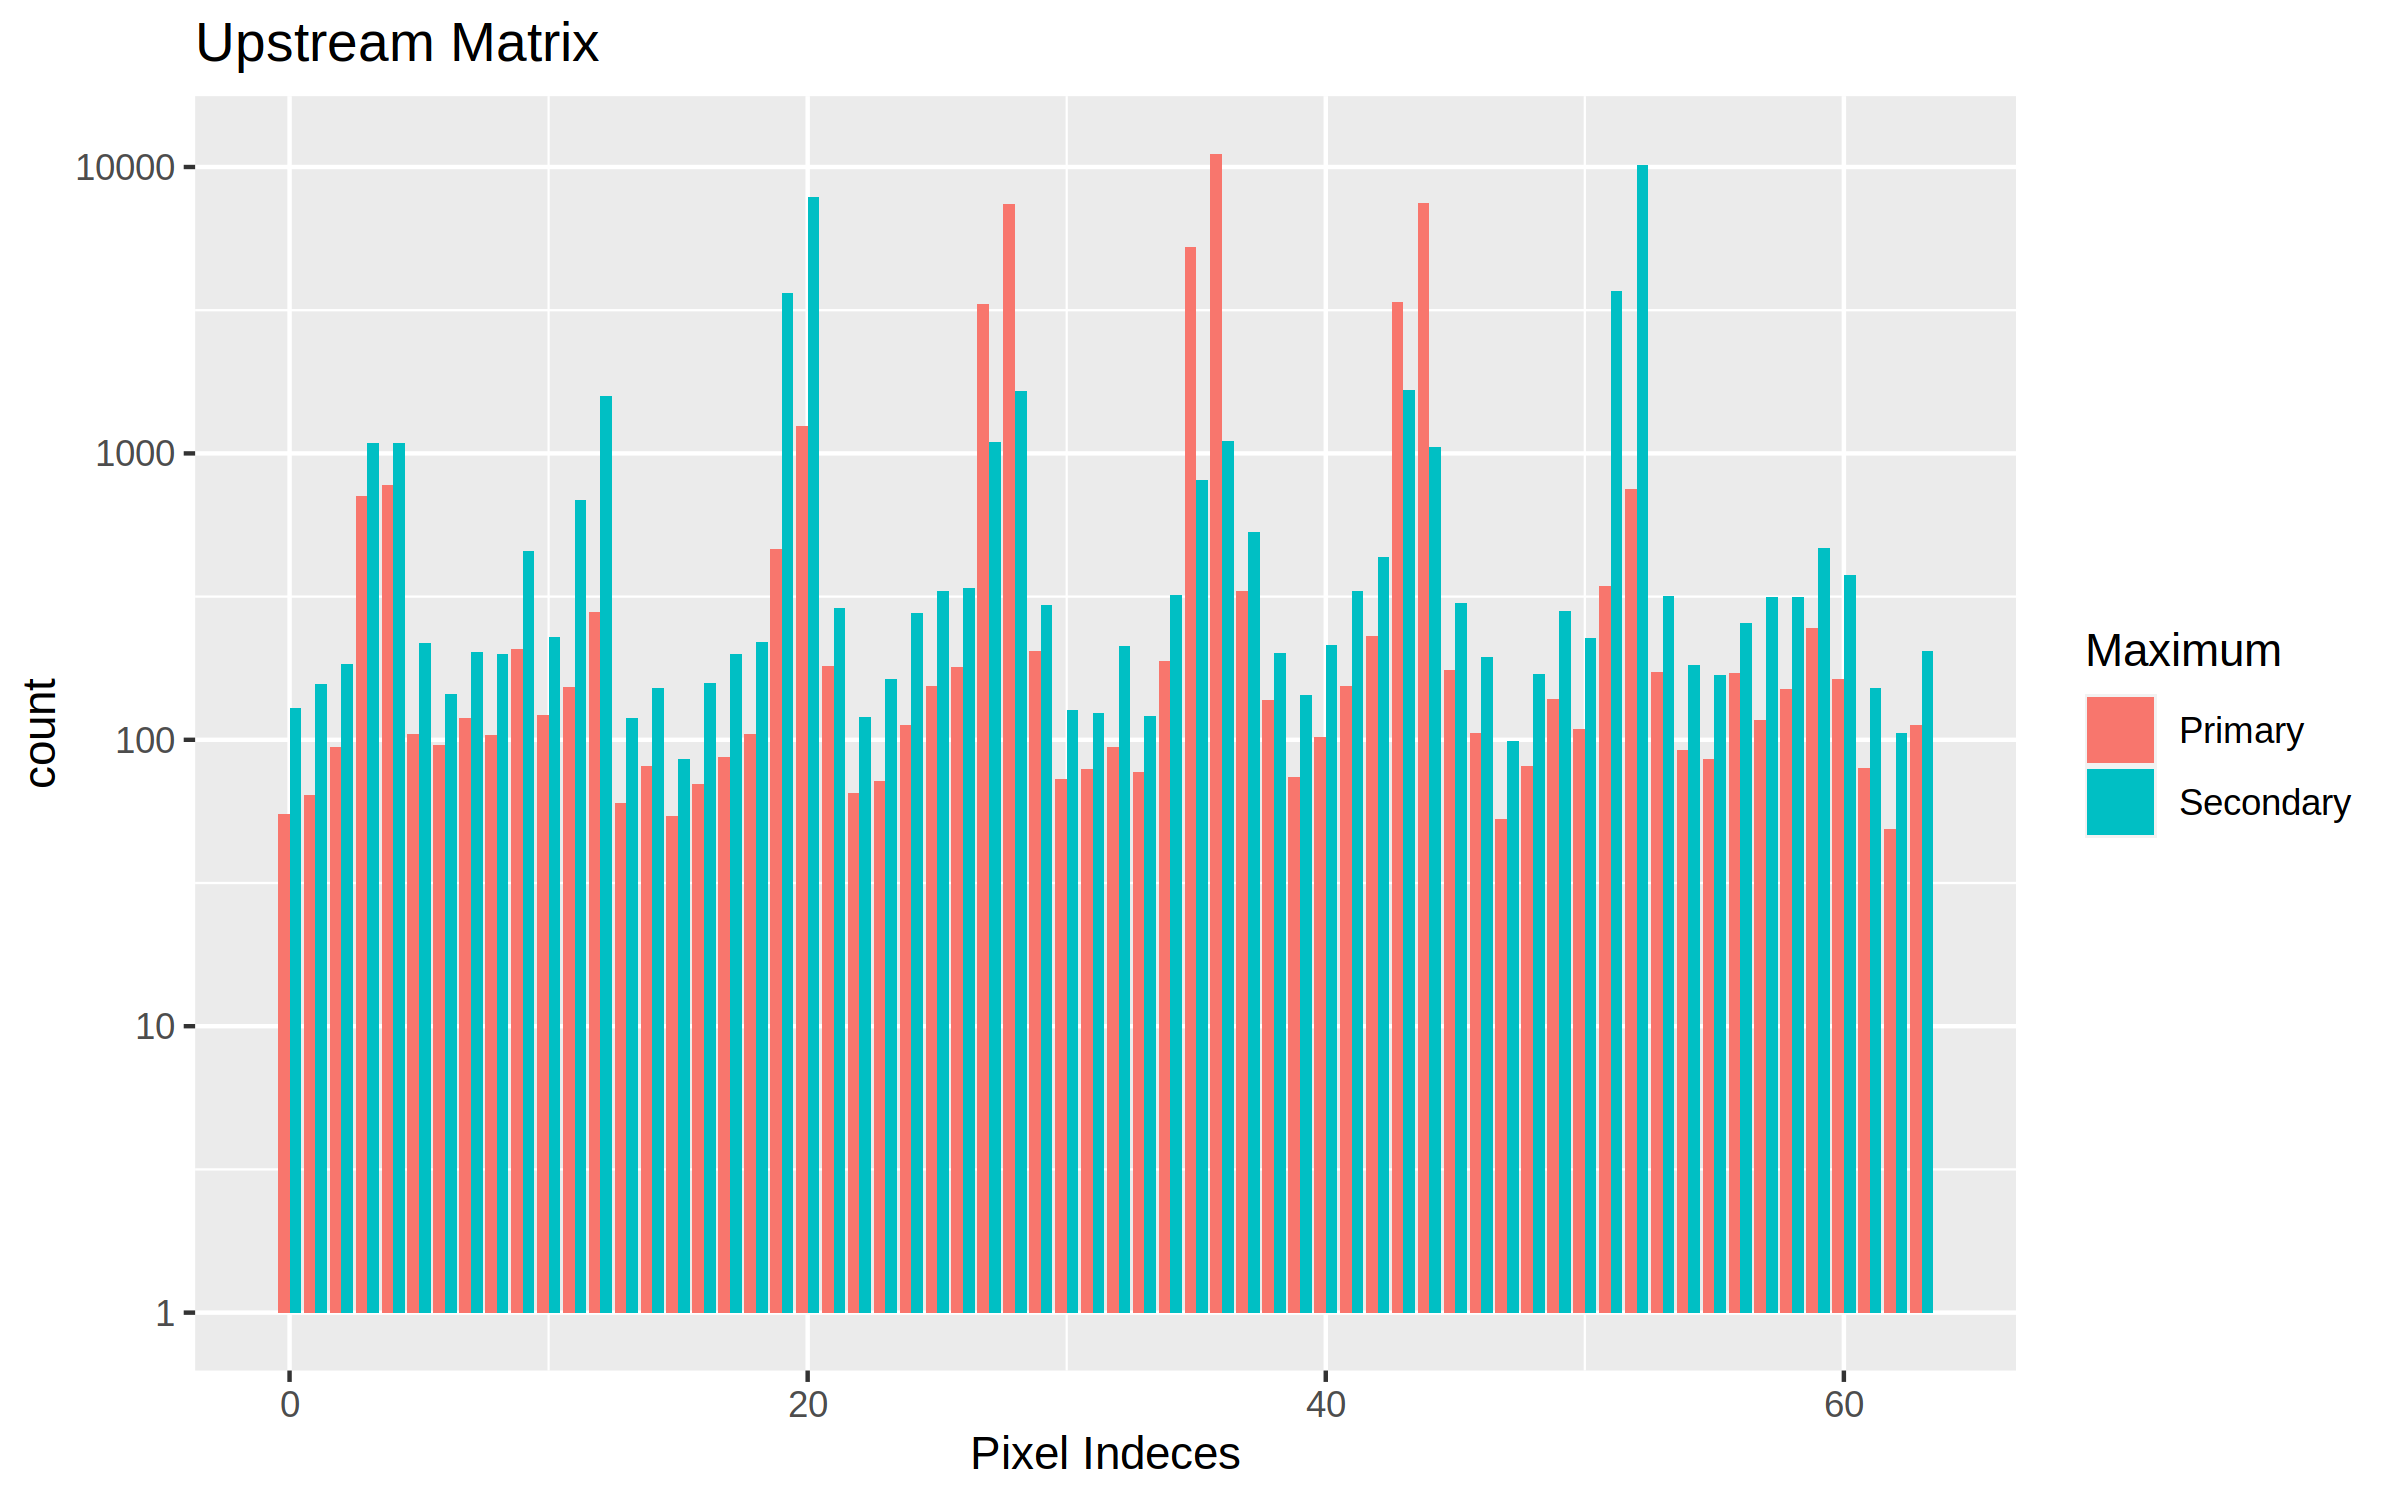

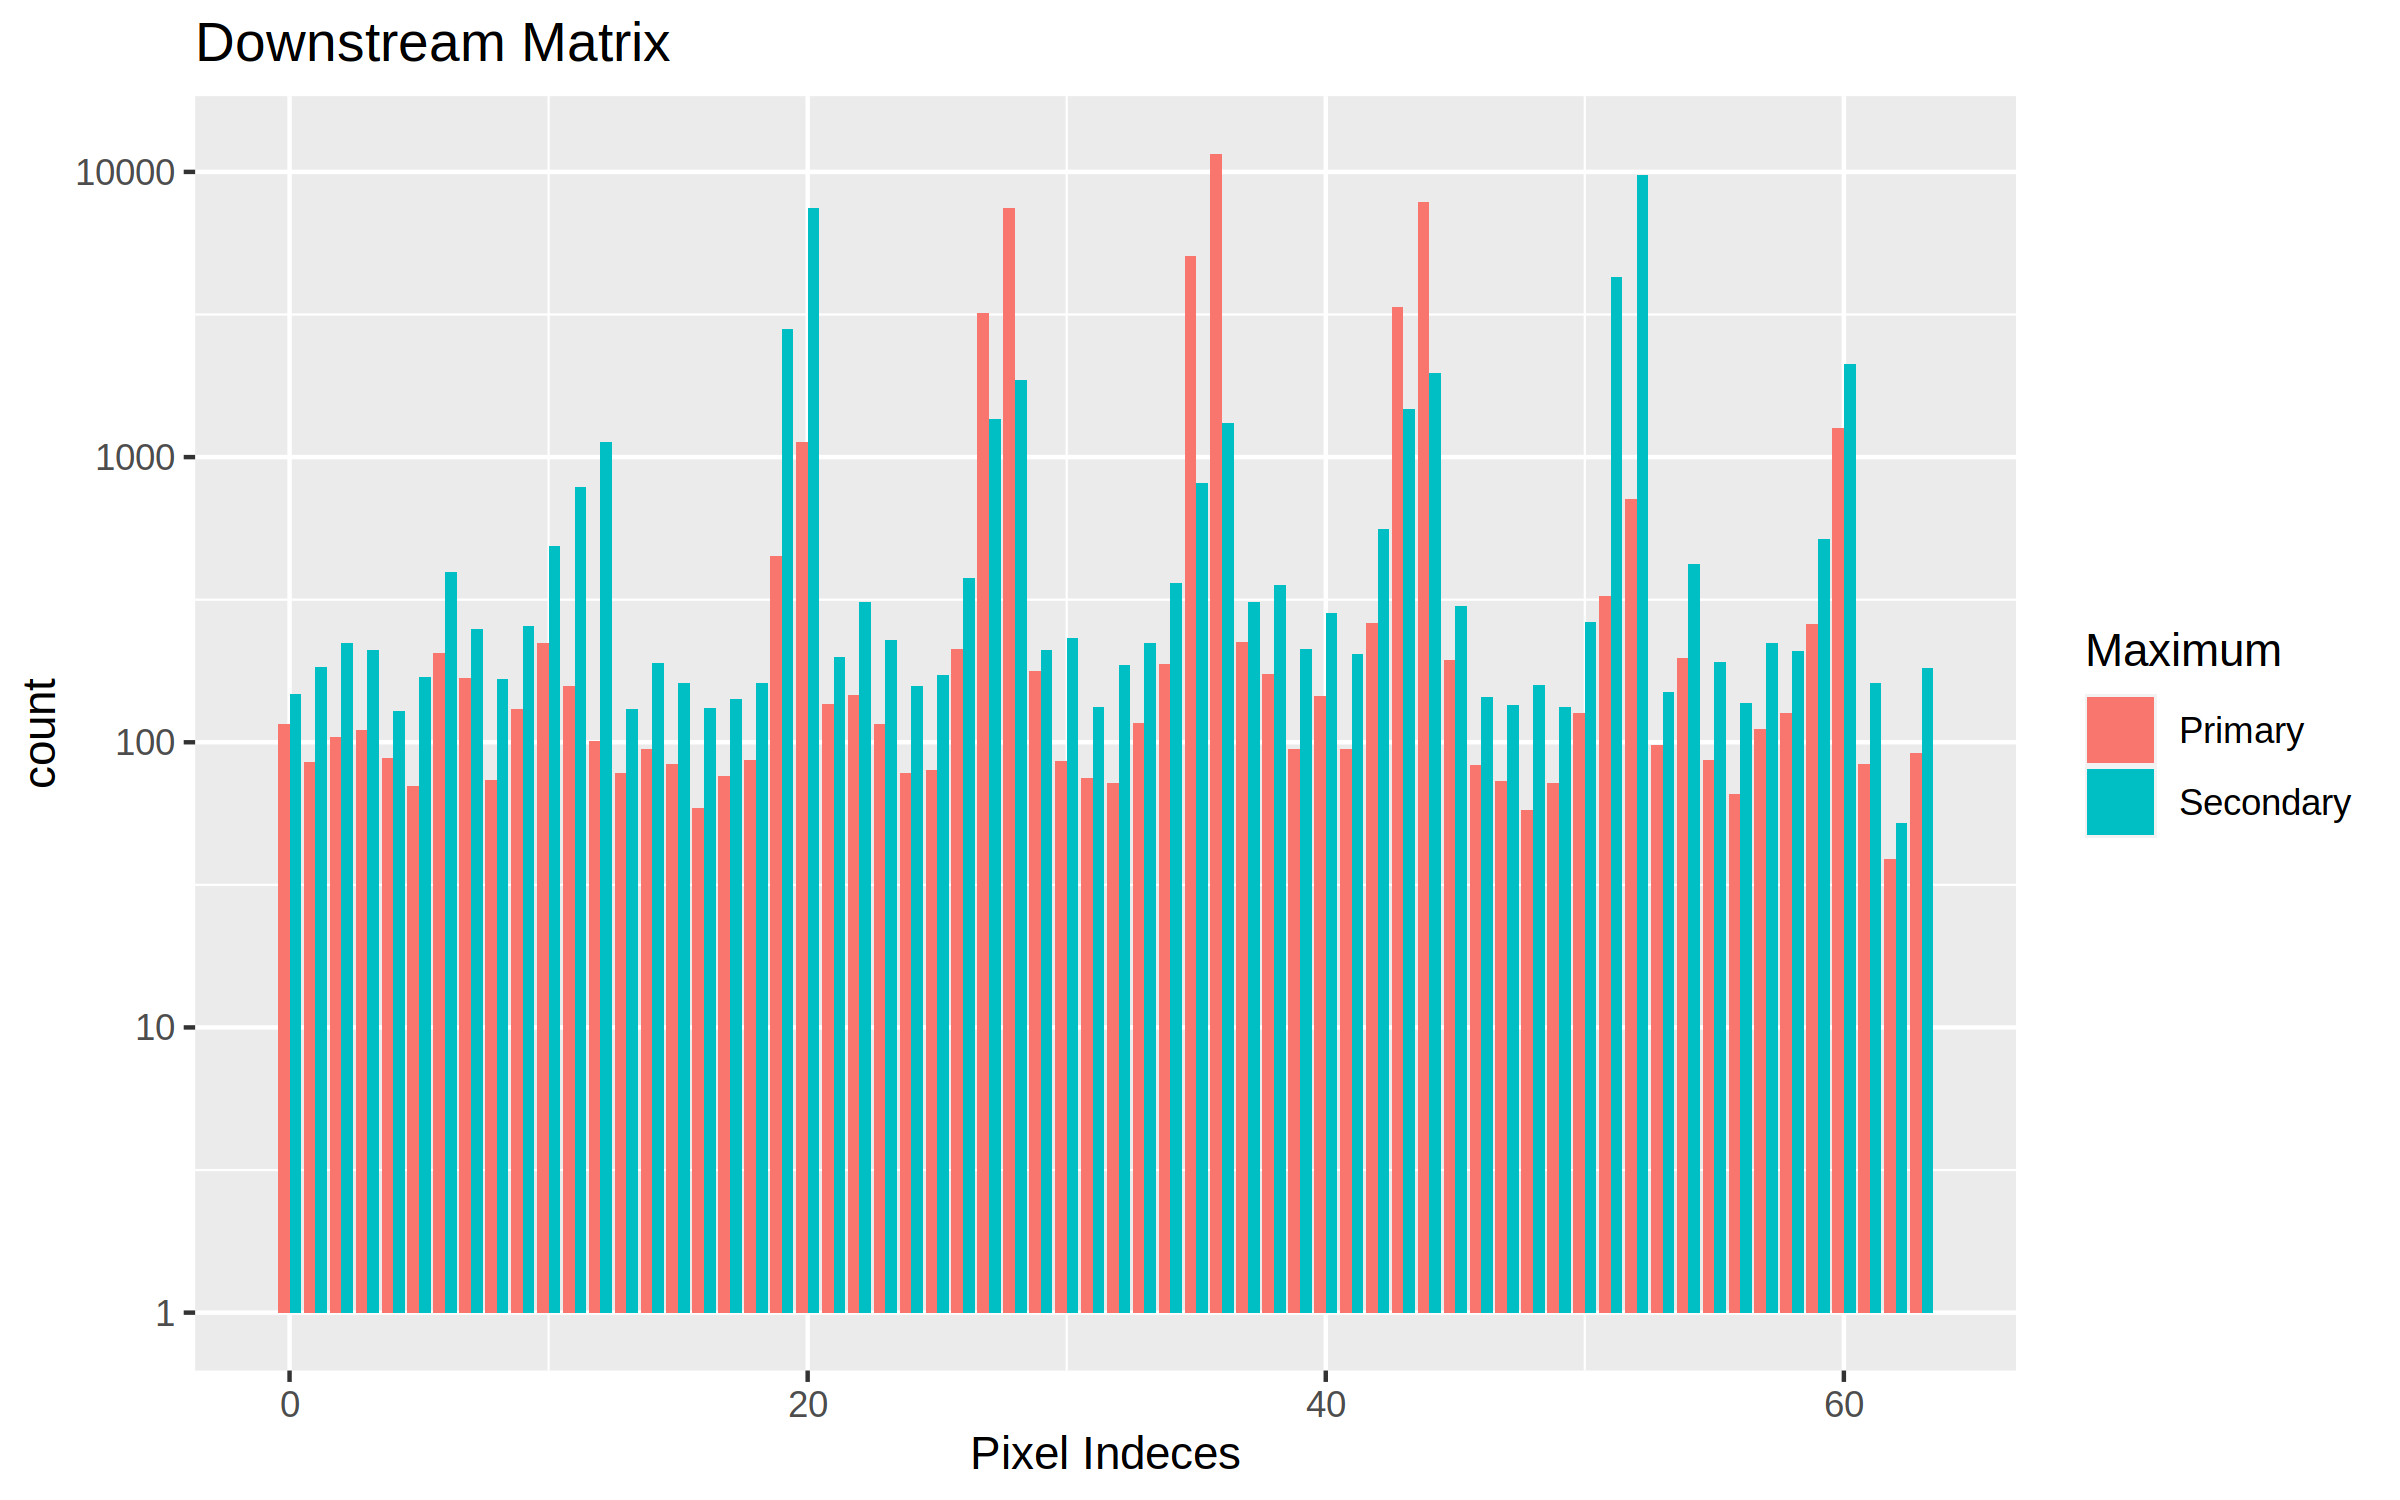

In [18]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 300)

ggplot(data=(lay.1 |> pivot_longer(c(px.idx.max, px.idx.max2))), aes(value, fill=name)) + geom_bar(position='dodge') + labs(title='Upstream Matrix', x='Pixel Indeces', fill='Maximum') + scale_fill_discrete(labels=c('Primary', 'Secondary')) + scale_y_log10()

ggplot(data=(lay.2 |> pivot_longer(c(px.idx.max, px.idx.max2))), aes(value, fill=name)) +
     geom_bar(position='dodge') + 
     labs(title='Downstream Matrix', x='Pixel Indeces', fill='Maximum') + 
     scale_fill_discrete(labels=c('Primary', 'Secondary')) +
     scale_y_log10()

## Filtered pixel indeces distribution

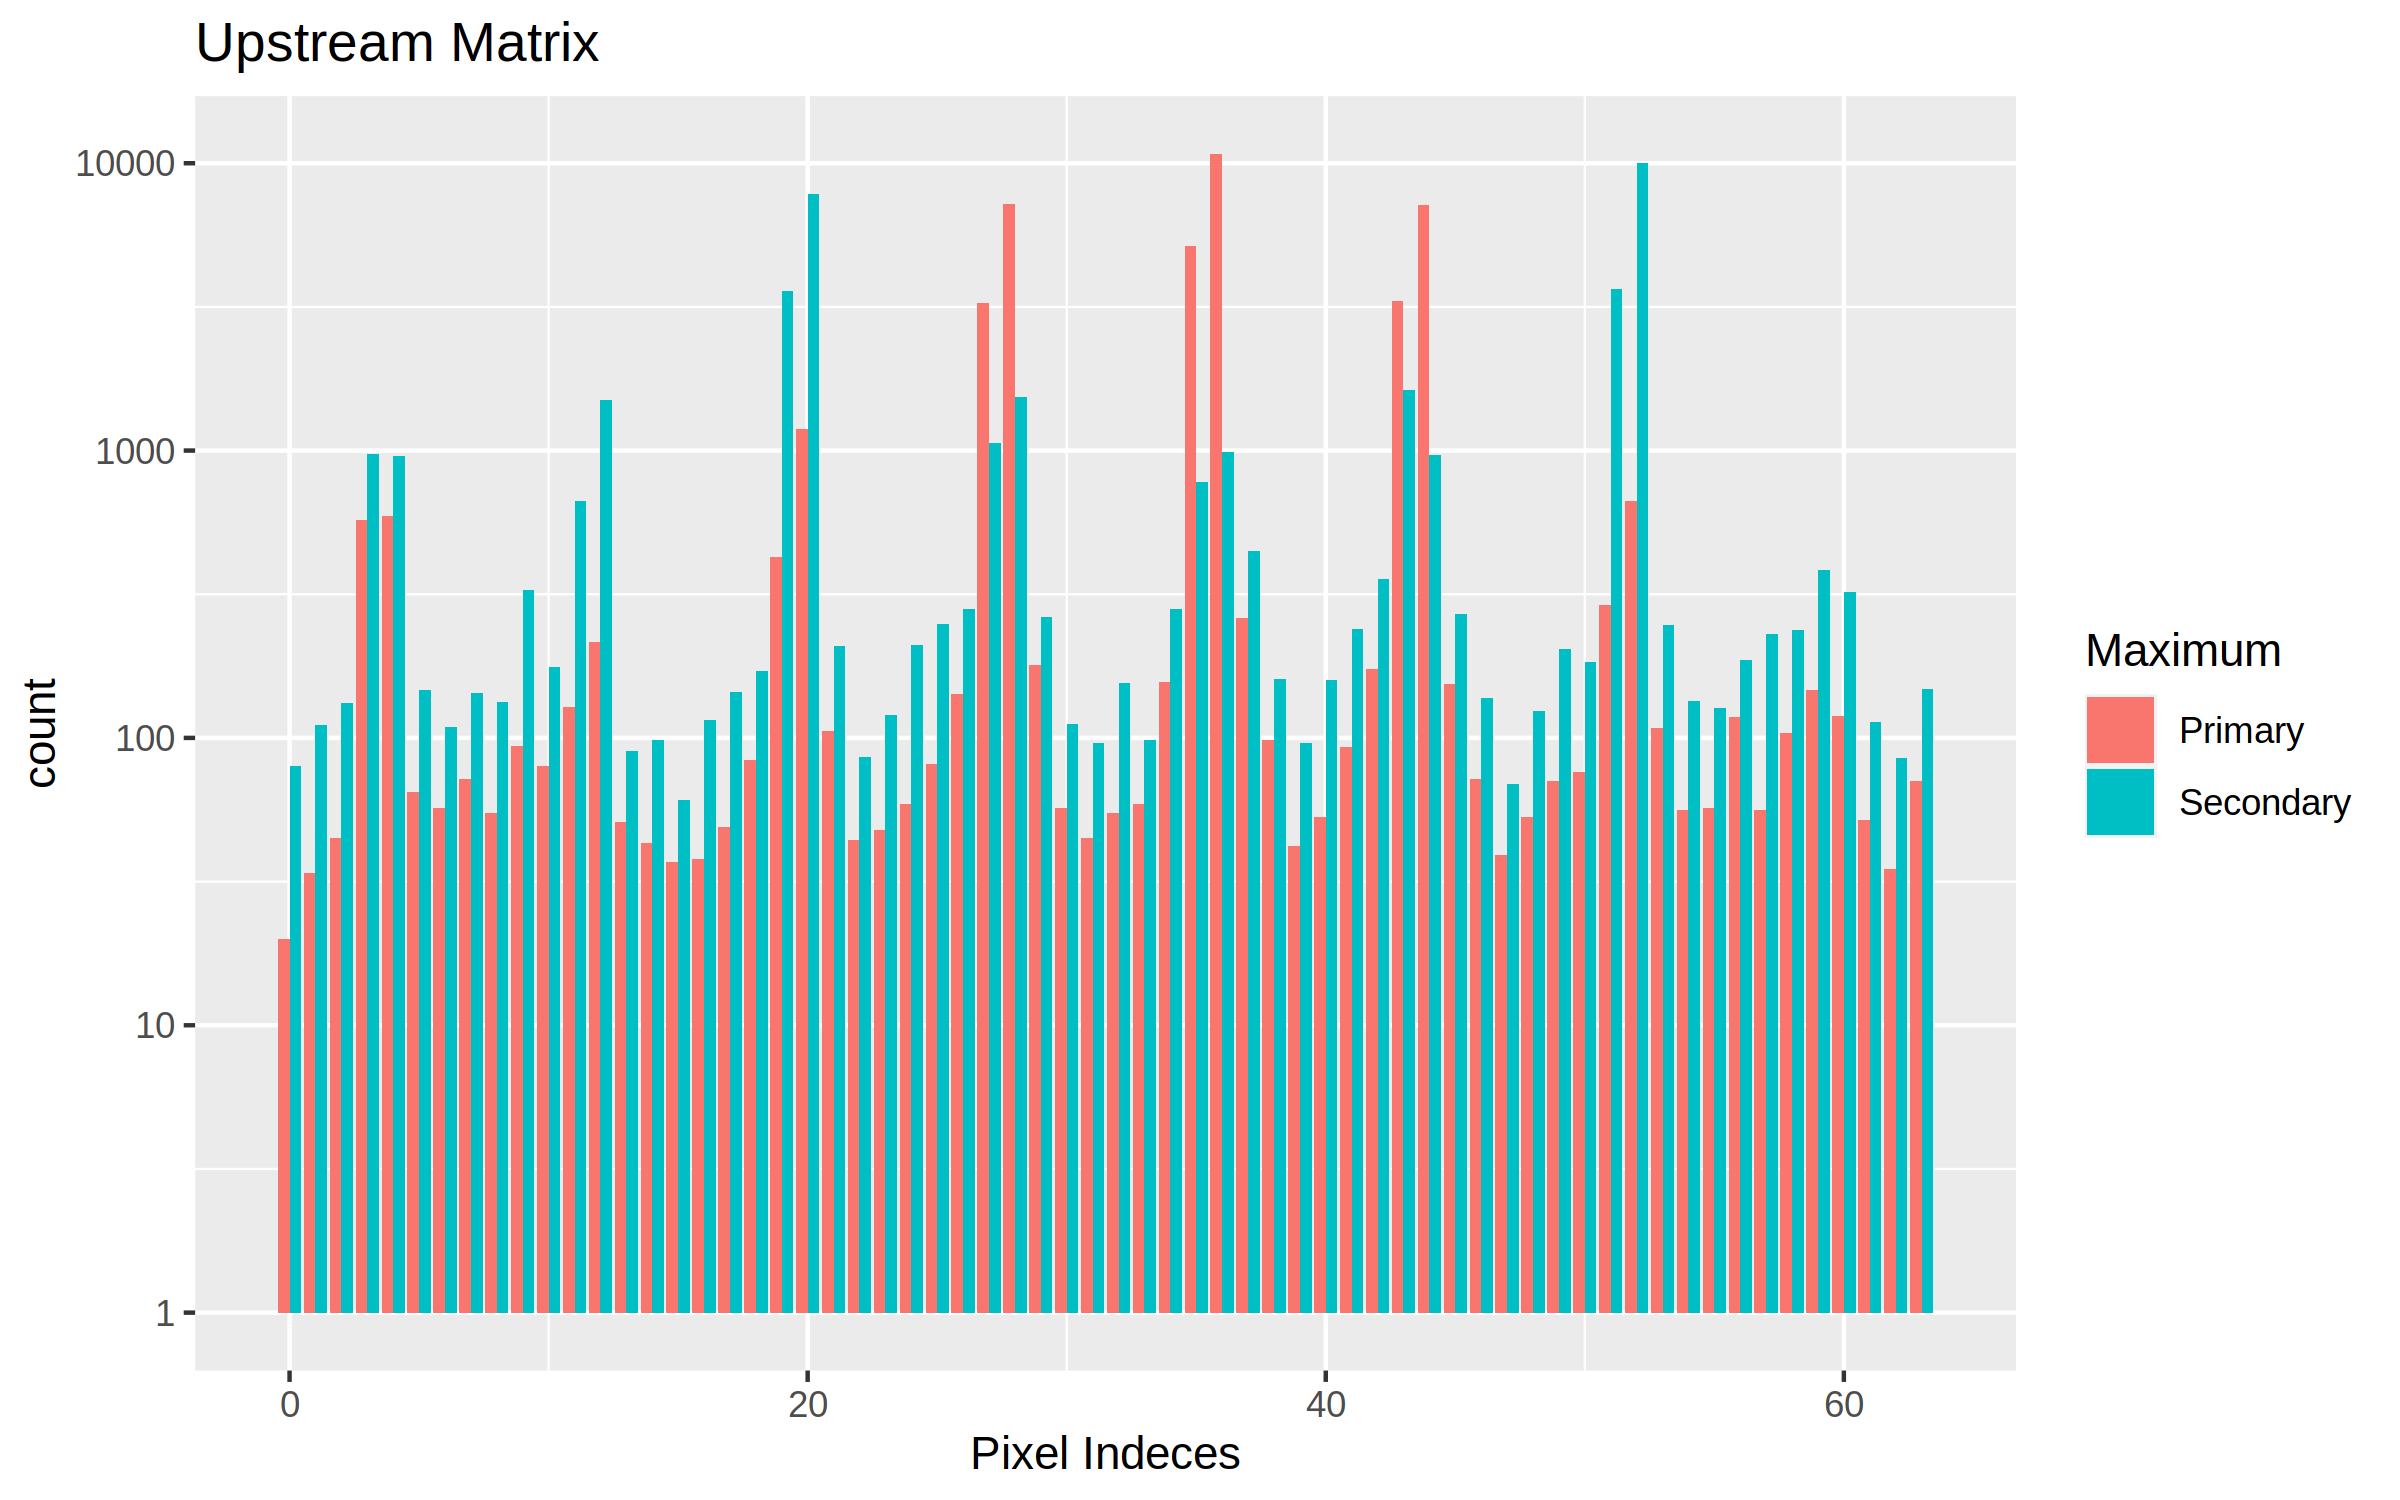

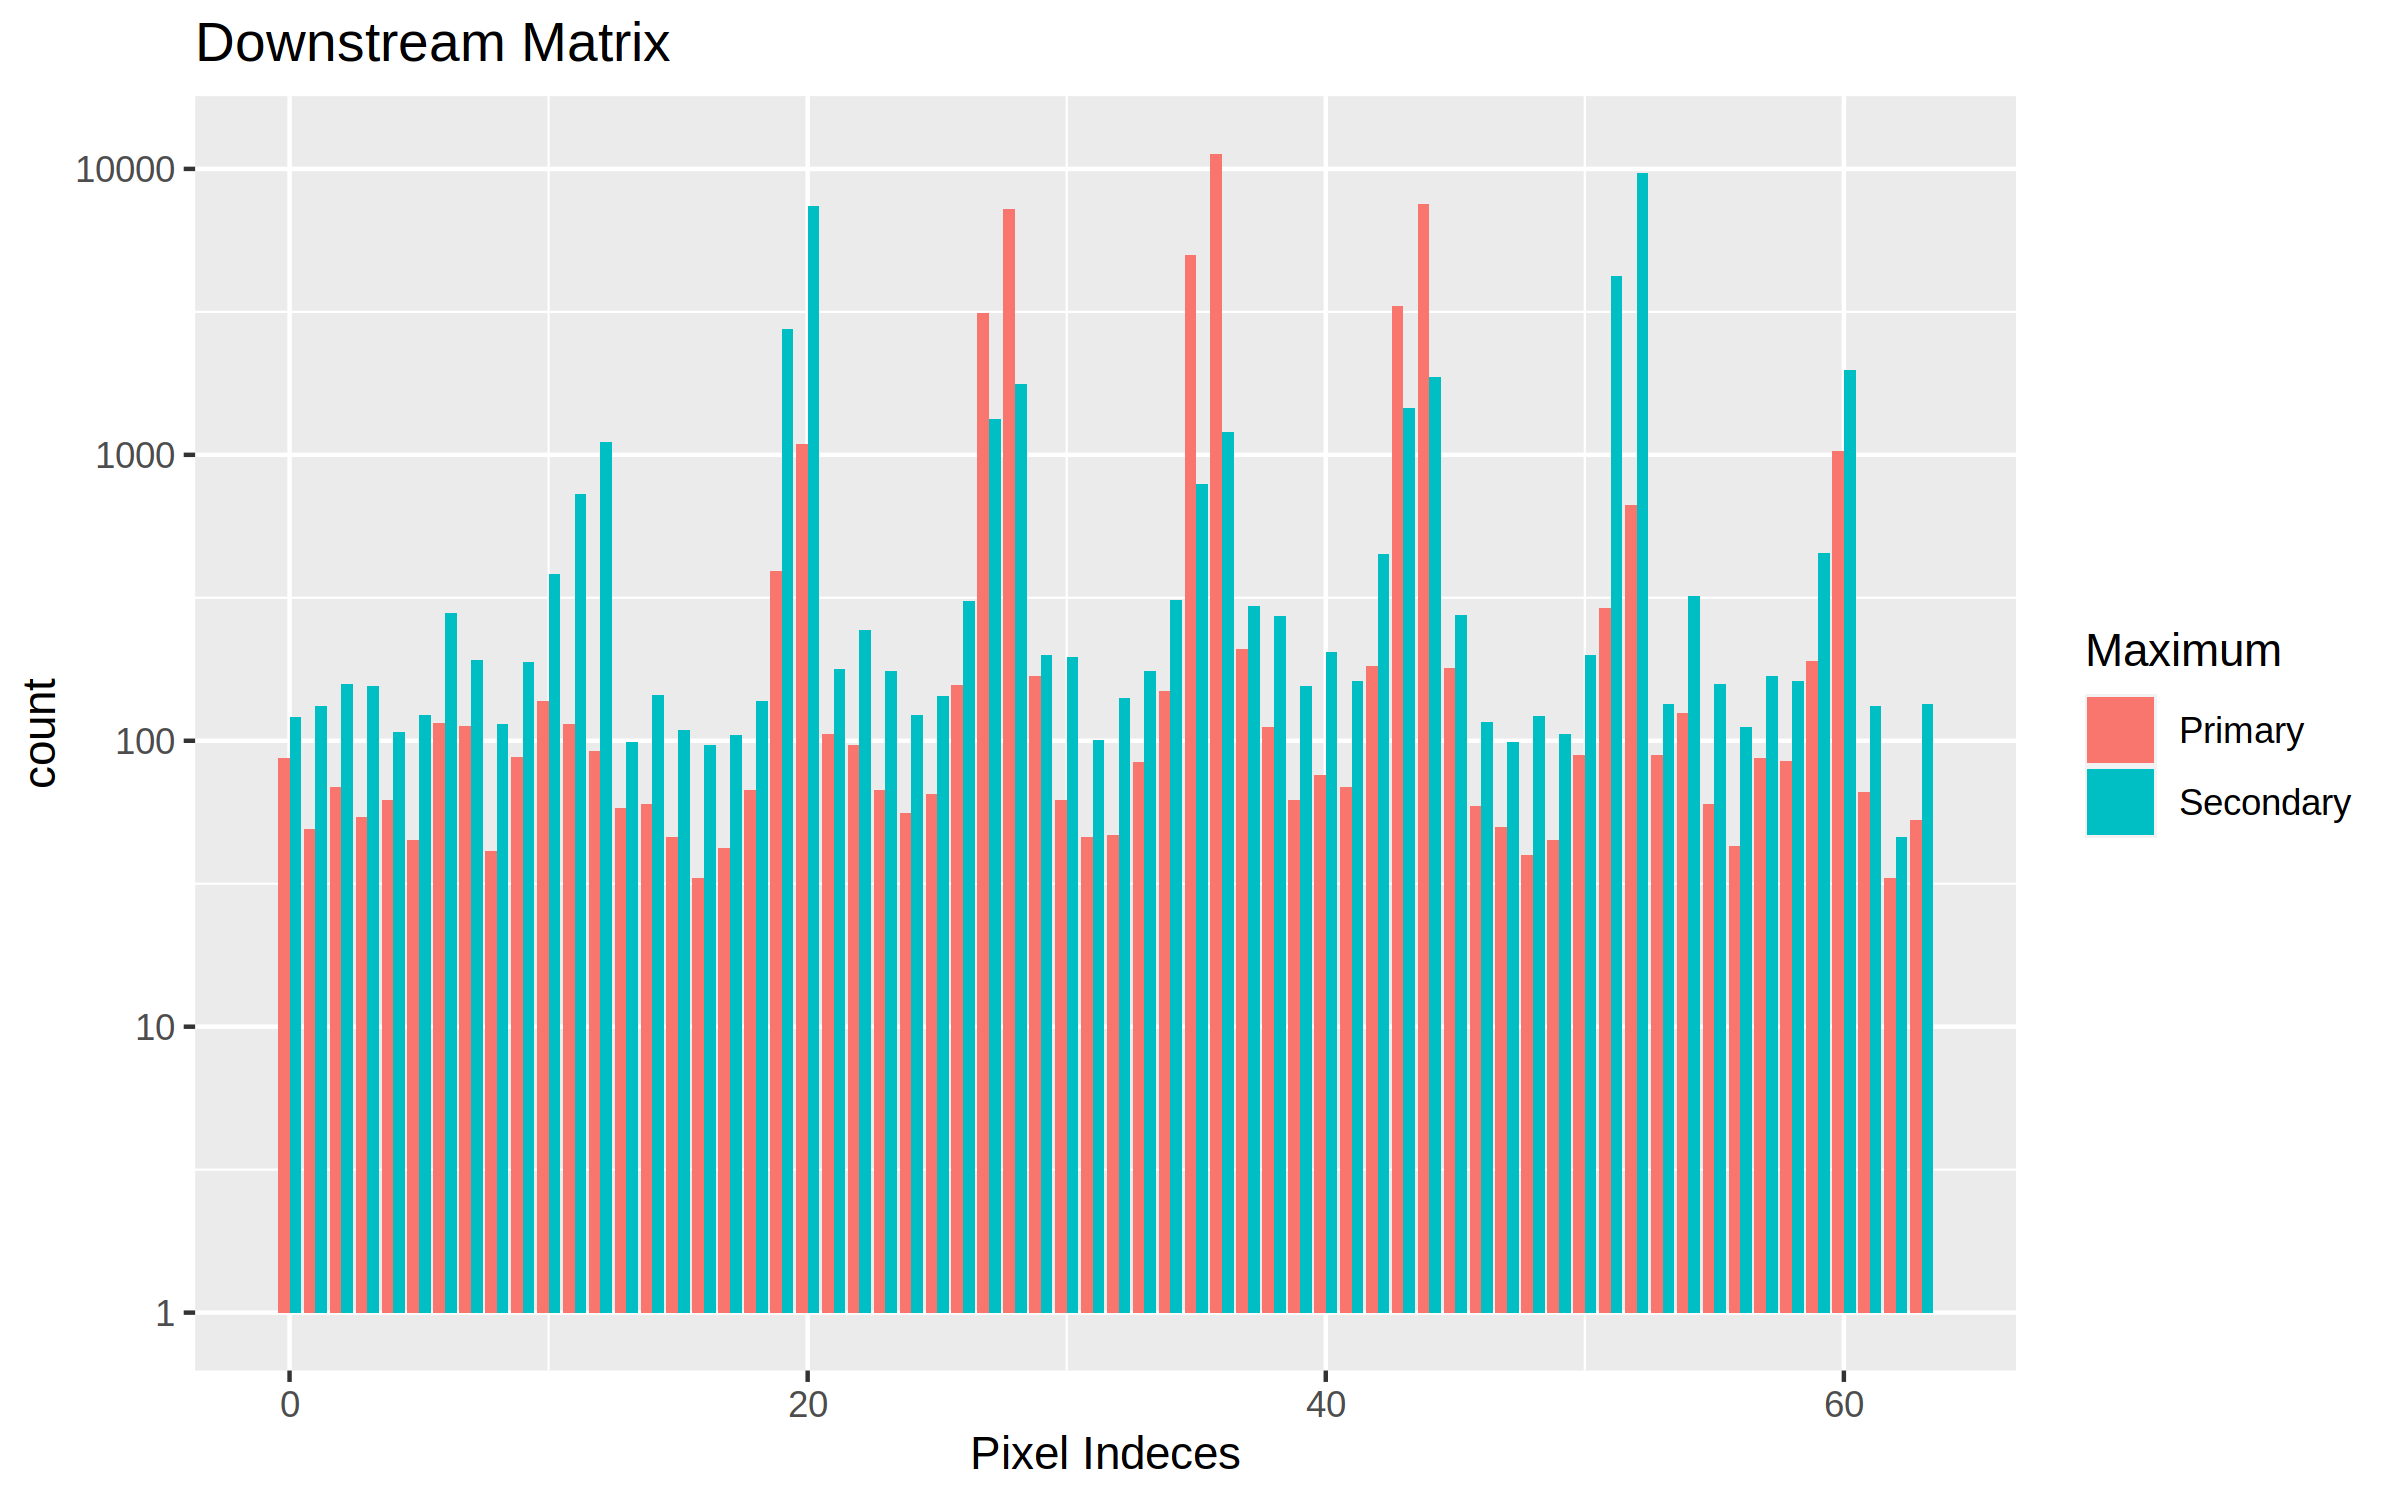

In [19]:
less.lay.1 <- lay.1 |> filter(max >= 10)
ggplot(data=(less.lay.1 |> pivot_longer(c(px.idx.max, px.idx.max2))), aes(value, fill=name)) +
     geom_bar(position='dodge') + 
     labs(title='Upstream Matrix', x='Pixel Indeces', fill='Maximum') + 
     scale_fill_discrete(labels=c('Primary', 'Secondary')) + 
     scale_y_log10()

less.lay.2 <- lay.2 |> filter(max >= 10)
ggplot(data=(less.lay.2 |> pivot_longer(c(px.idx.max, px.idx.max2))), aes(value, fill=name)) +
     geom_bar(position='dodge') + 
     labs(title='Downstream Matrix', x='Pixel Indeces', fill='Maximum') + 
     scale_fill_discrete(labels=c('Primary', 'Secondary')) +
     scale_y_log10()

## Ratio distributions

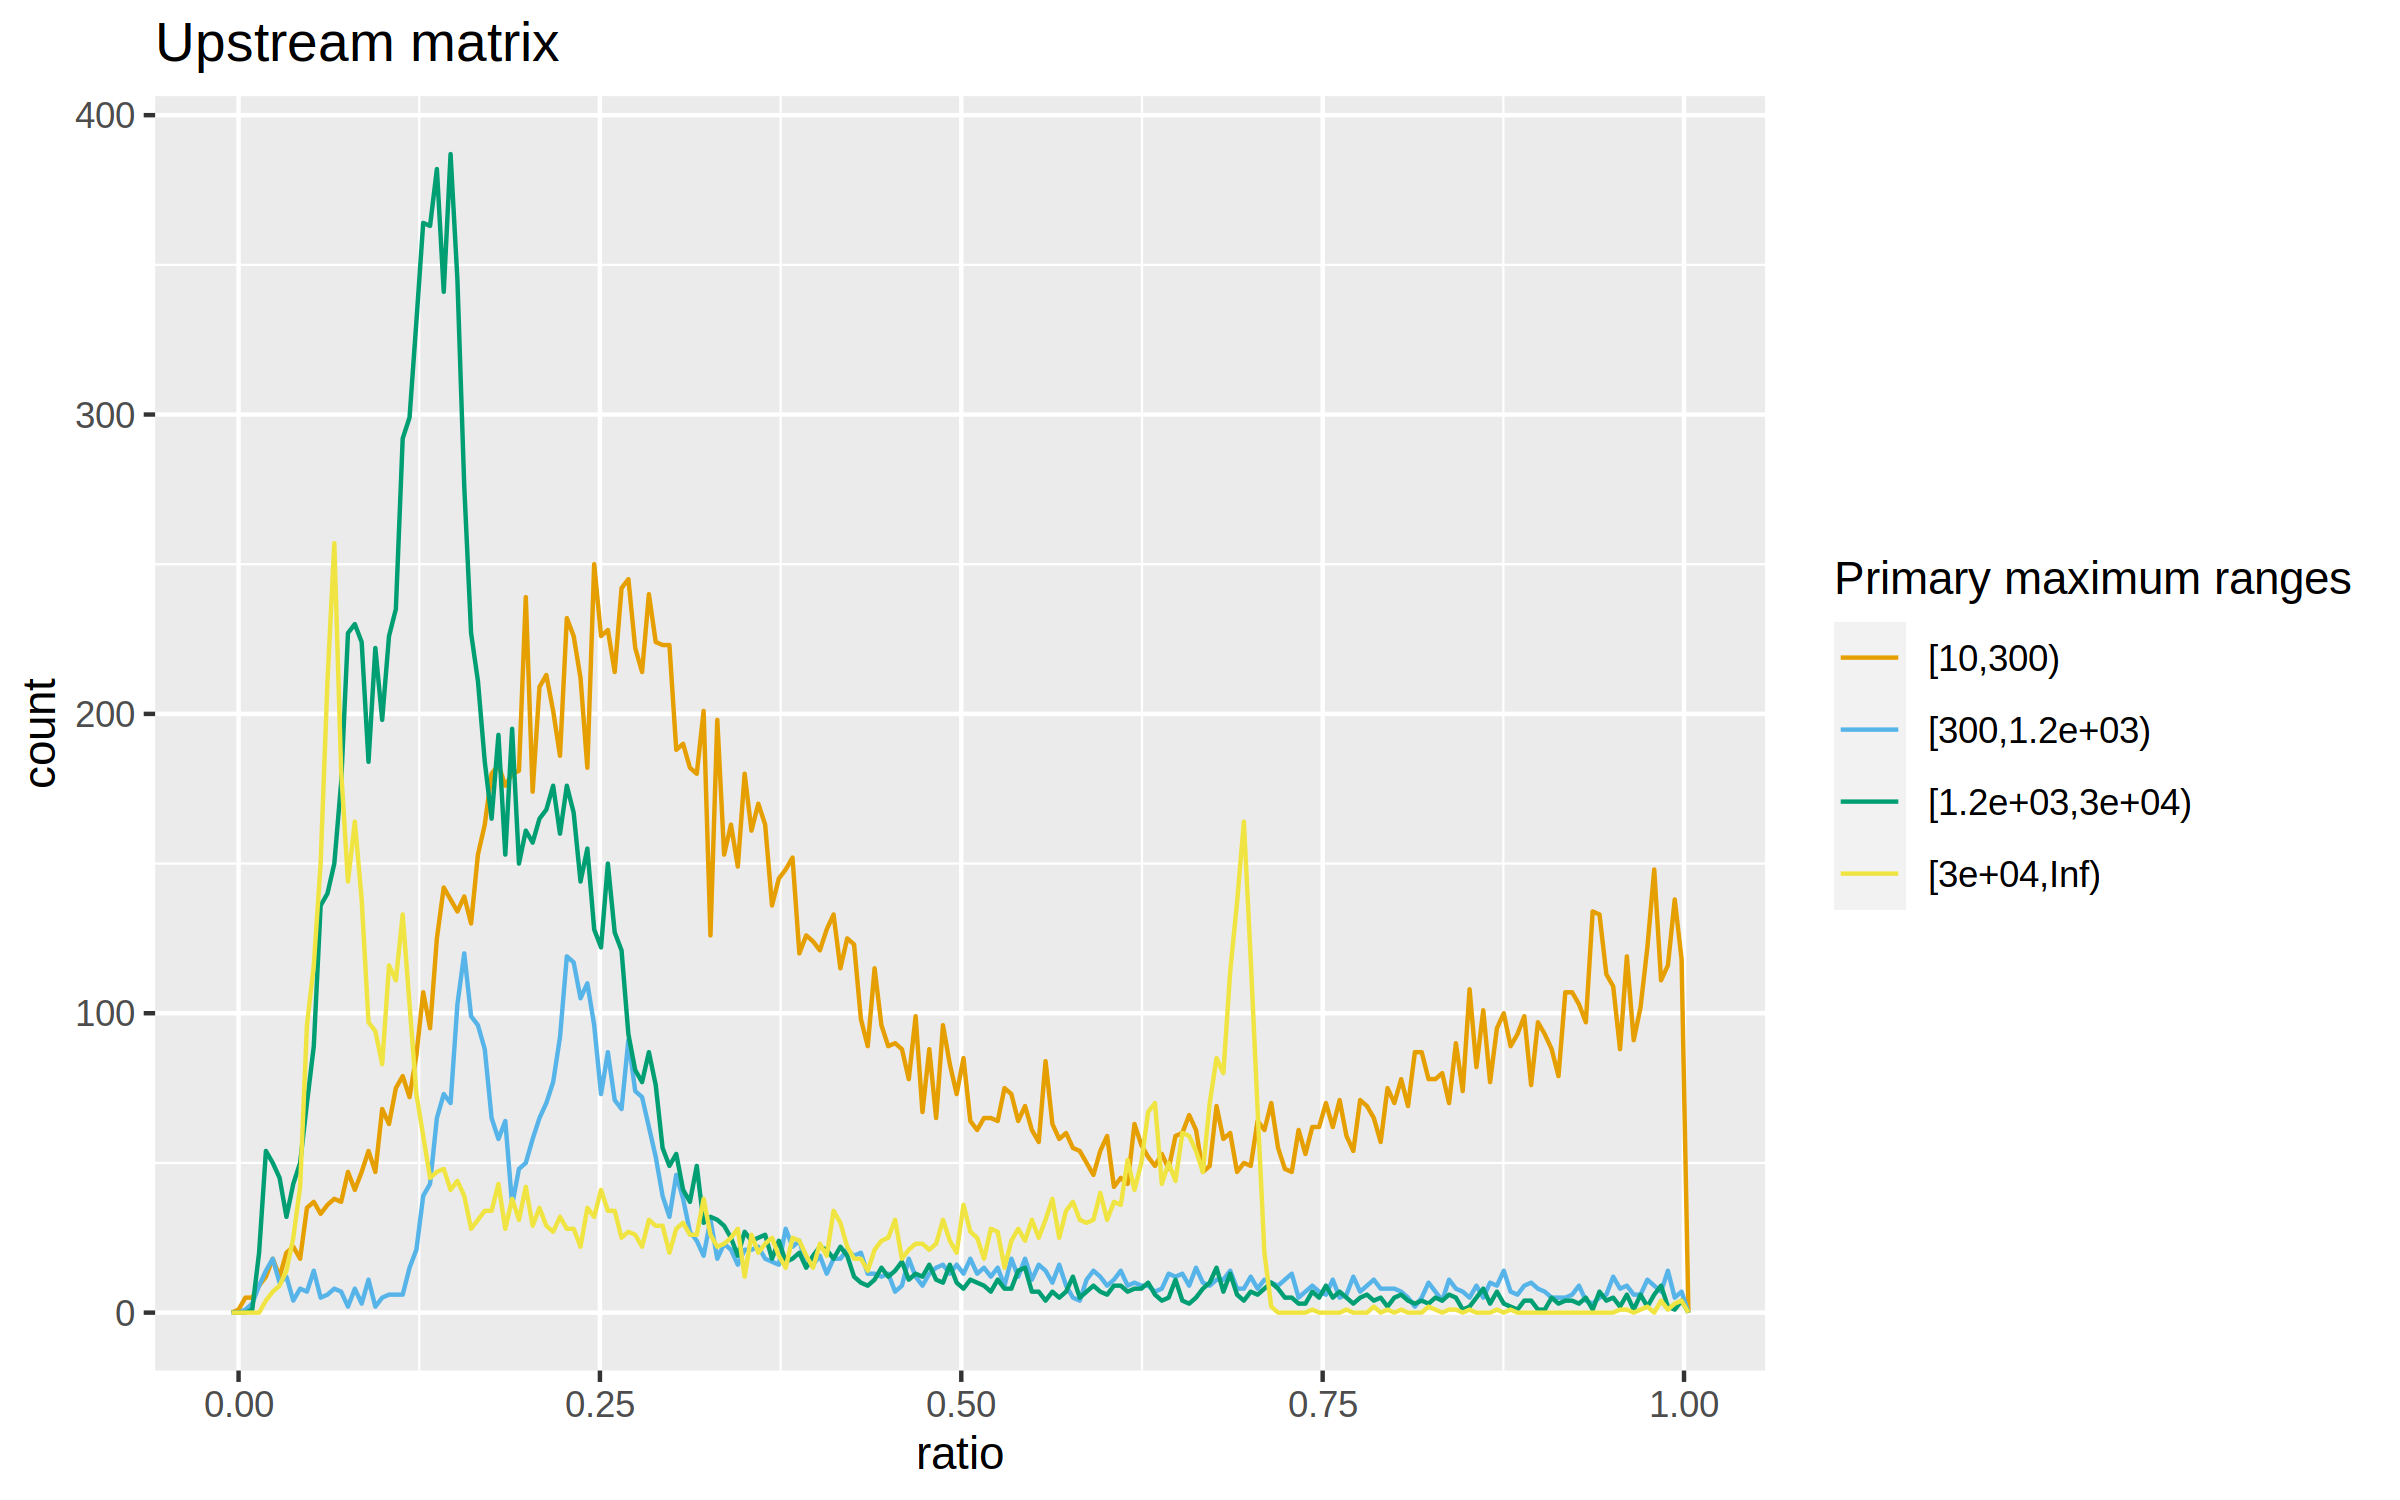

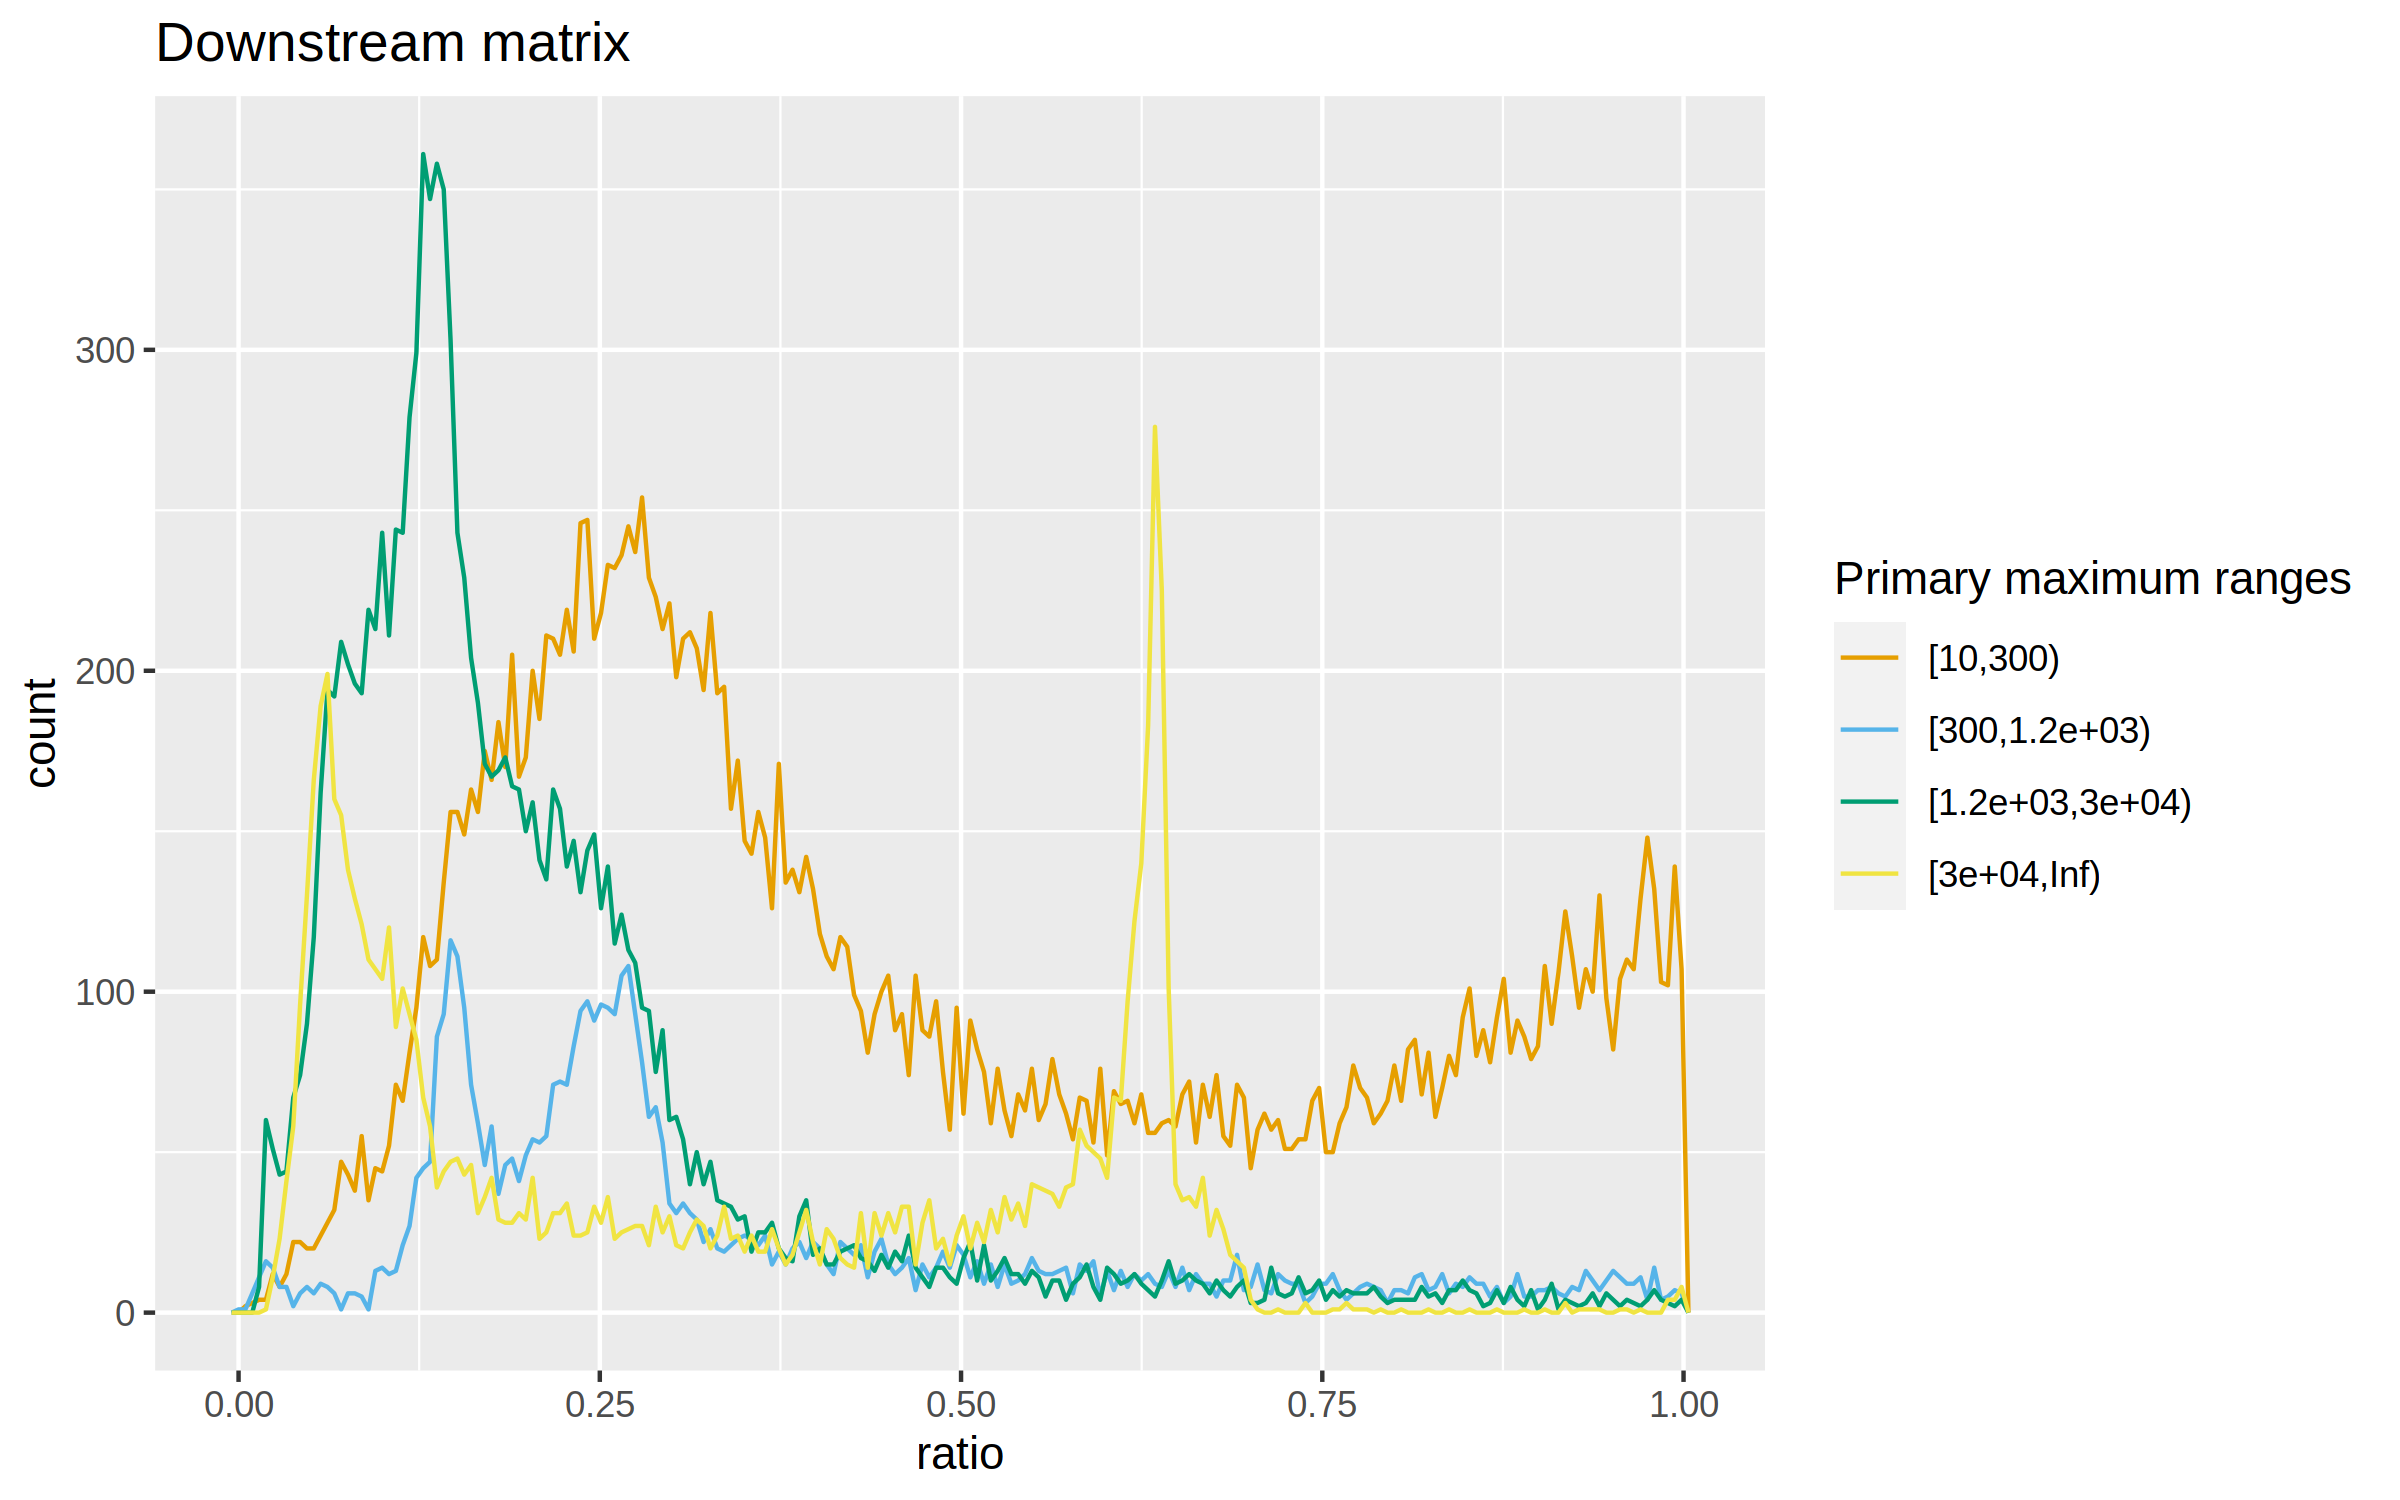

In [20]:
less.lay.1 <- less.lay.1 |> mutate(ratio = max2 / max)
less.lay.2 <- less.lay.2 |> mutate(ratio = max2 / max)

# By definition max2 < max, so one only needs to filter out rows where max2 > 0
lesser.lay.1 <- less.lay.1 |> filter(max2 > 0) |> mutate(max.group = cut(max, c(10, 300, 1200, 30000, Inf), right = F))
lesser.lay.2 <- less.lay.2 |> filter(max2 > 0) |> mutate(max.group = cut(max, c(10, 300, 1200, 30000, Inf), right = F))

ggplot(data=lesser.lay.1, mapping=aes(ratio, color=max.group)) +
    geom_freqpoly(bins = as.integer(sqrt(dim(less.lay.1)[1]))) +
    scale_color_okabe_ito(name='Primary maximum ranges') + labs(title='Upstream matrix')


ggplot(data=lesser.lay.2, mapping=aes(ratio, color=max.group)) +
    geom_freqpoly(bins = as.integer(sqrt(dim(less.lay.1)[1]))) +
    scale_color_okabe_ito(name='Primary maximum ranges') + labs(title='Downstream matrix')

## Matrices heatmaps

In [21]:
less.lay.1 <- less.lay.1 |> mutate(row.max=px.idx.max %% 8, col.max=px.idx.max %/% 8, row.max2=px.idx.max2 %% 8, col.max2=px.idx.max2 %/% 8)
less.lay.2 <- less.lay.2 |> mutate(row.max=px.idx.max %% 8, col.max=px.idx.max %/% 8, row.max2=px.idx.max2 %% 8, col.max2=px.idx.max2 %/% 8)

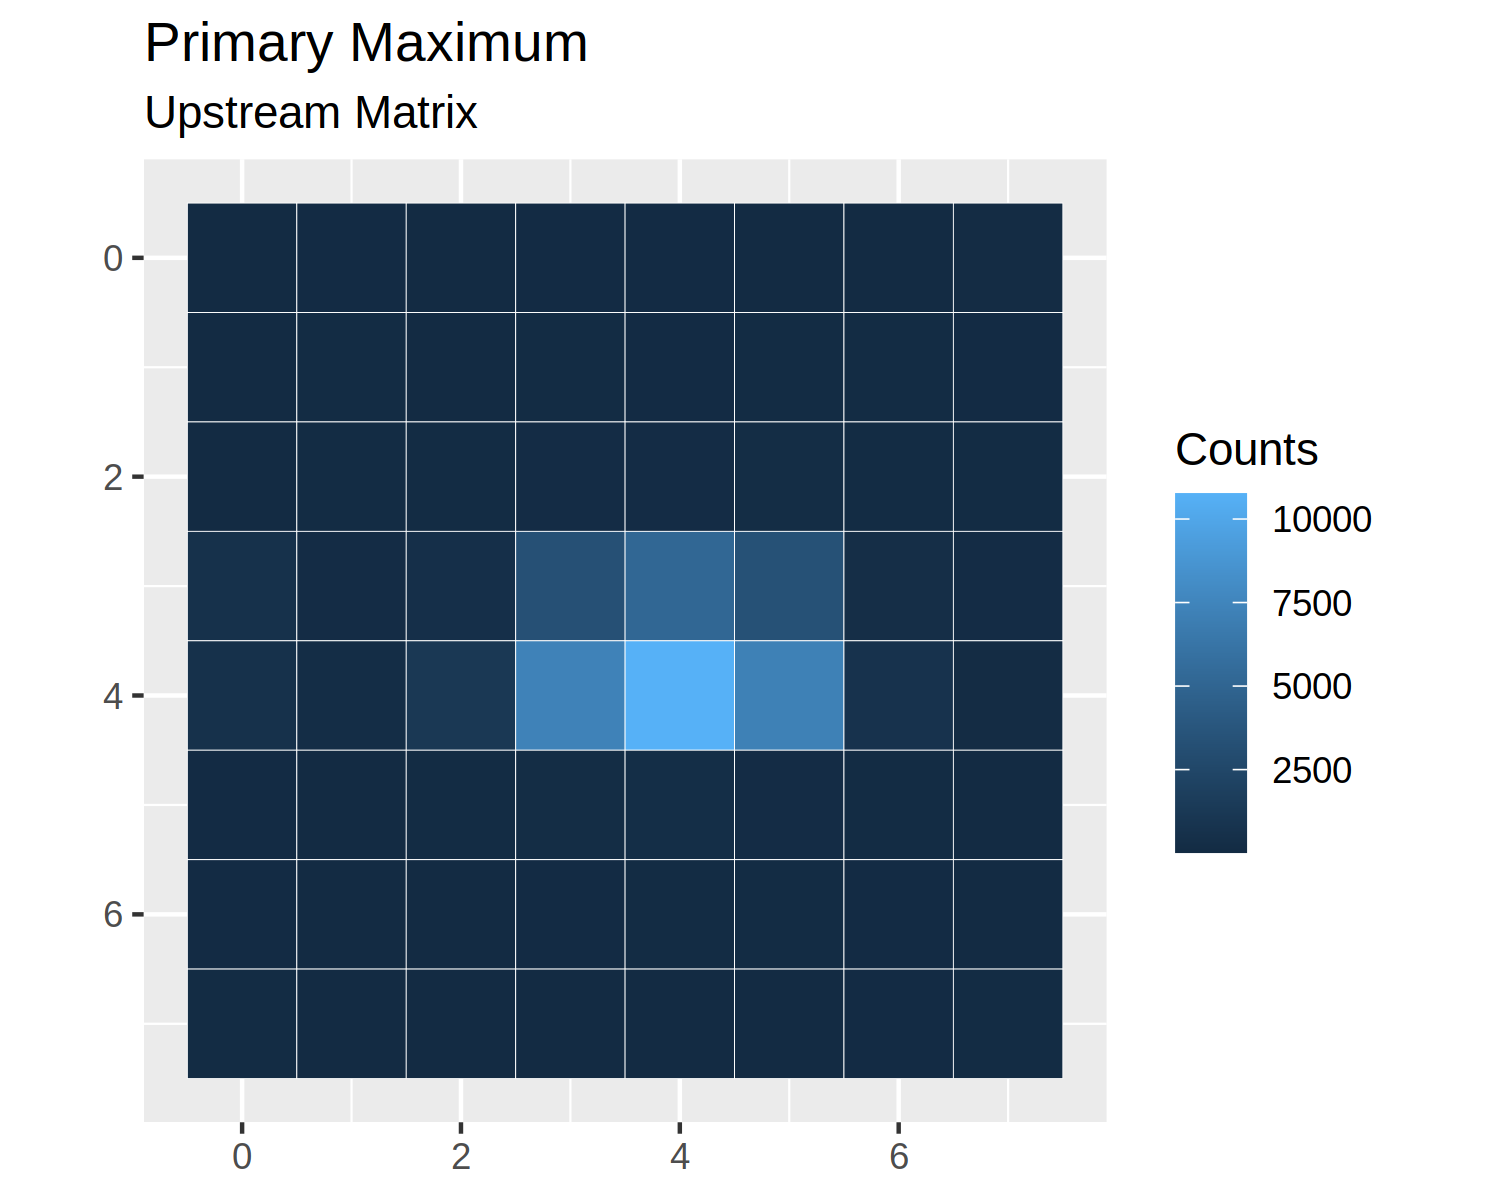

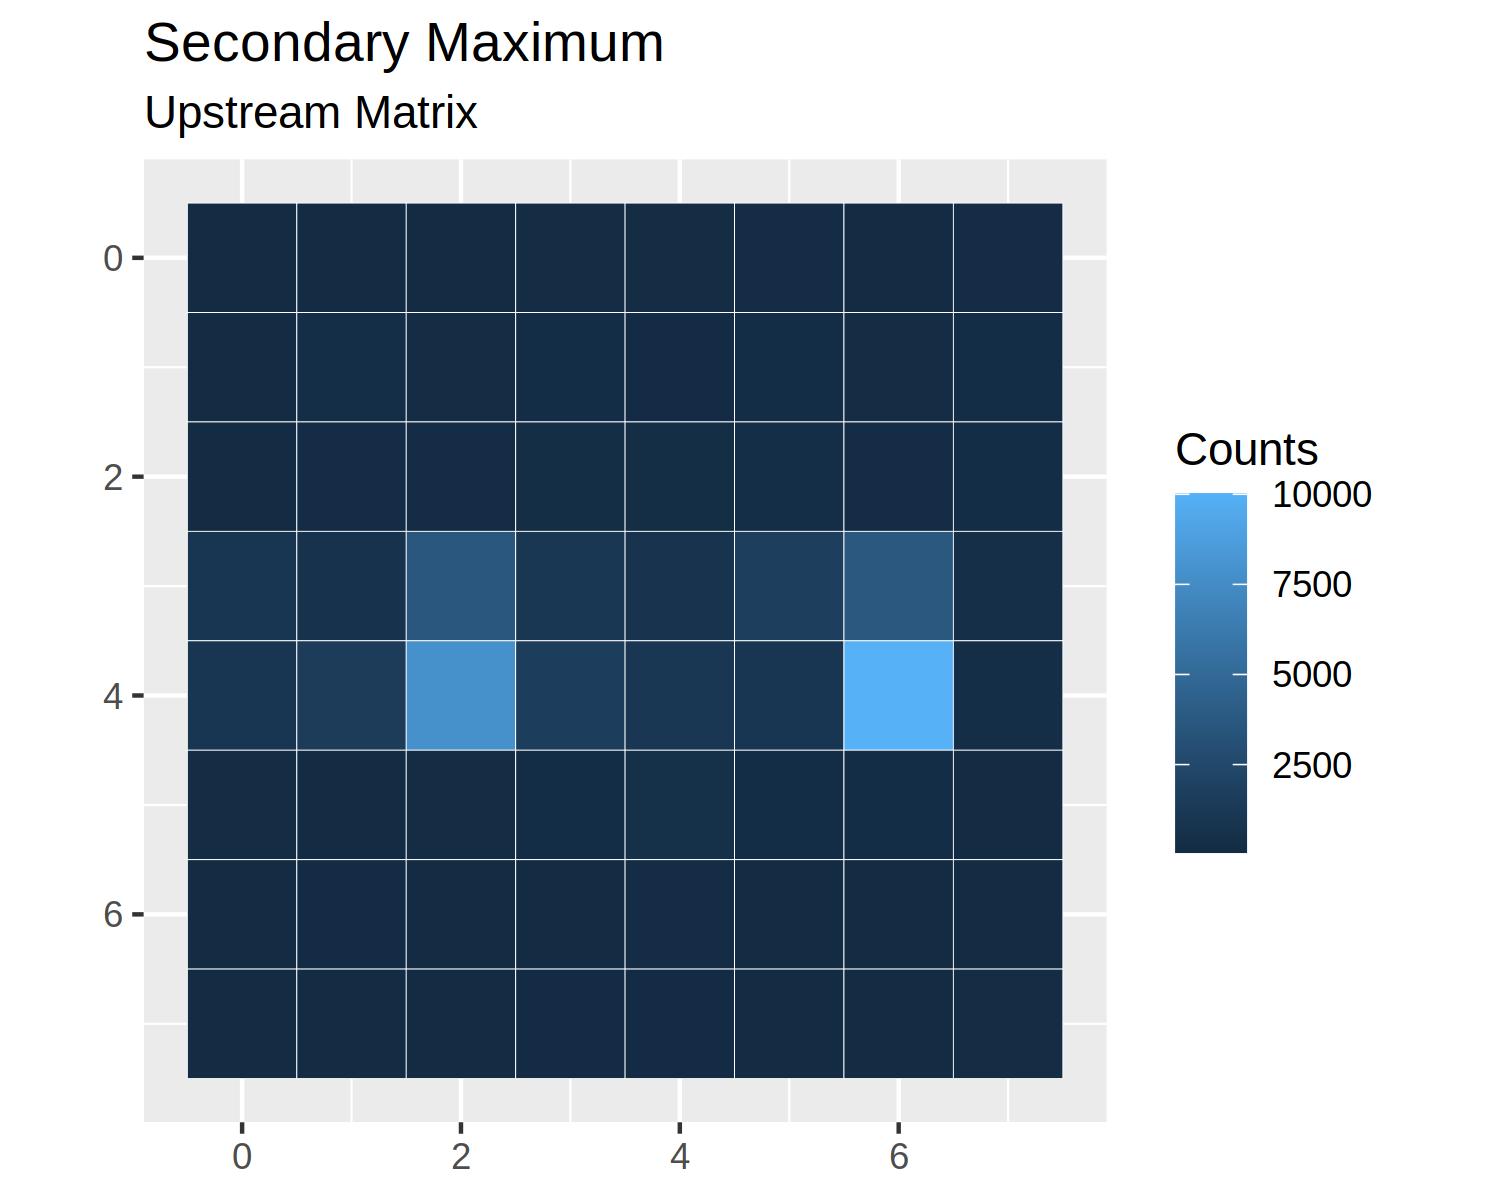

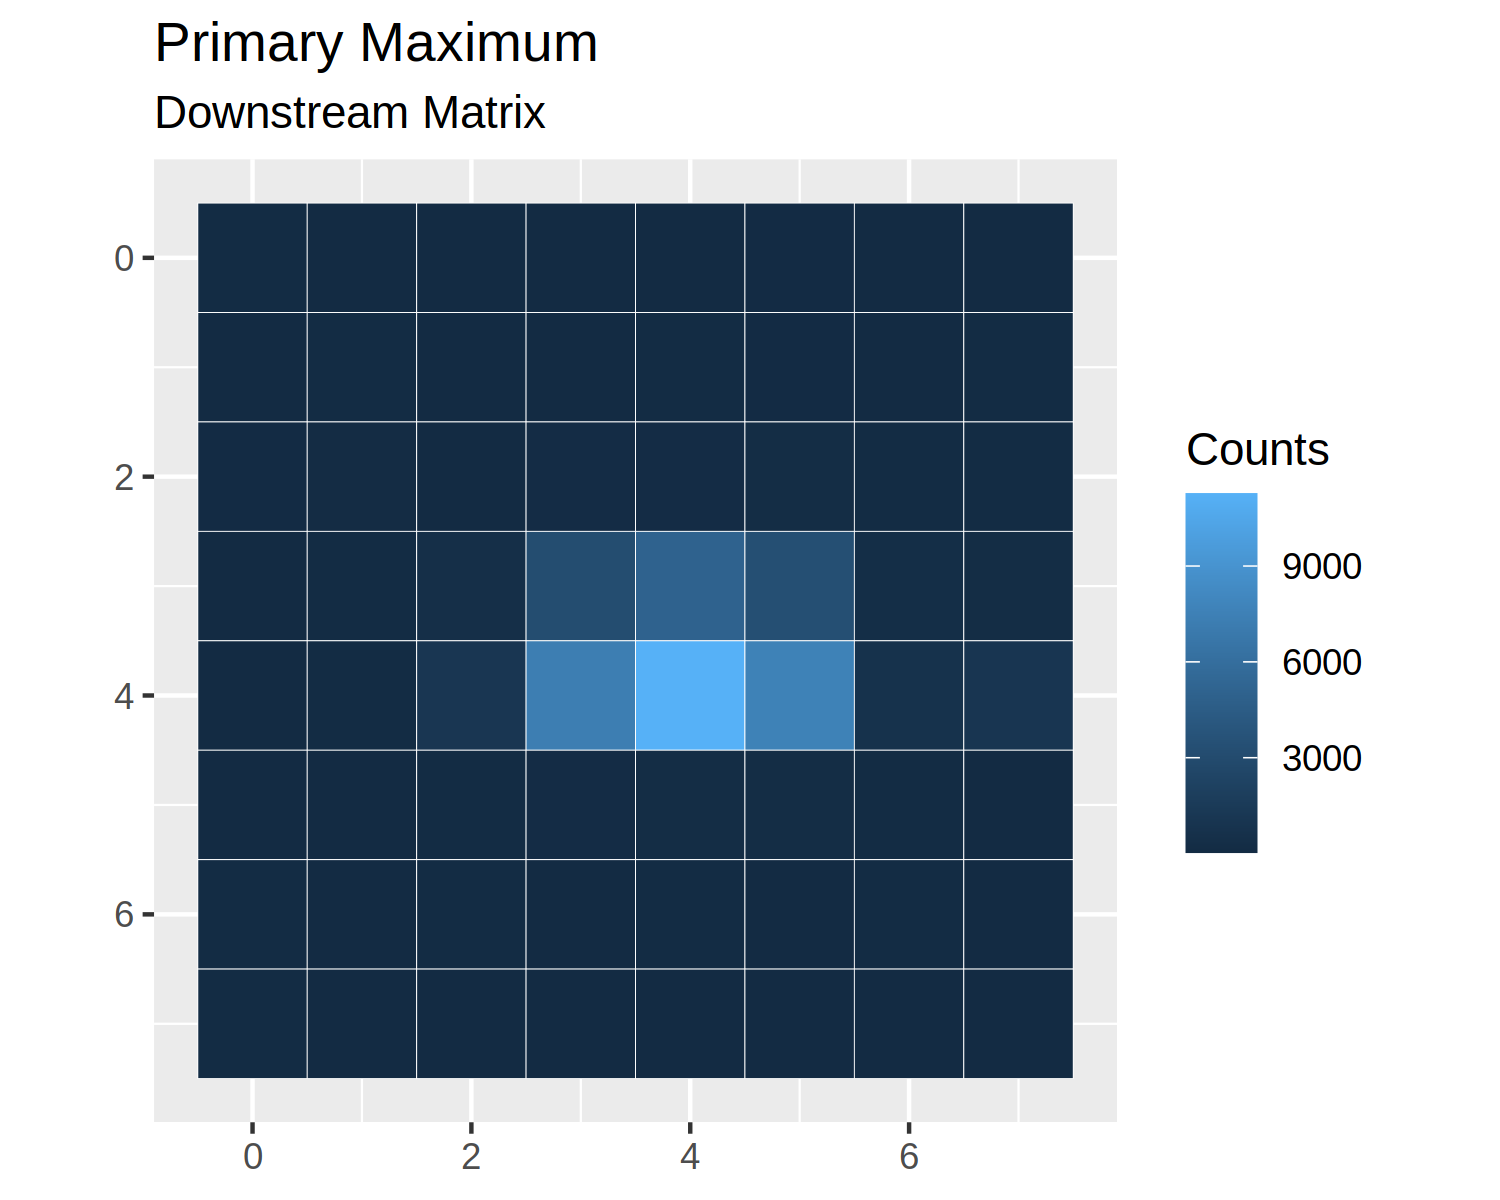

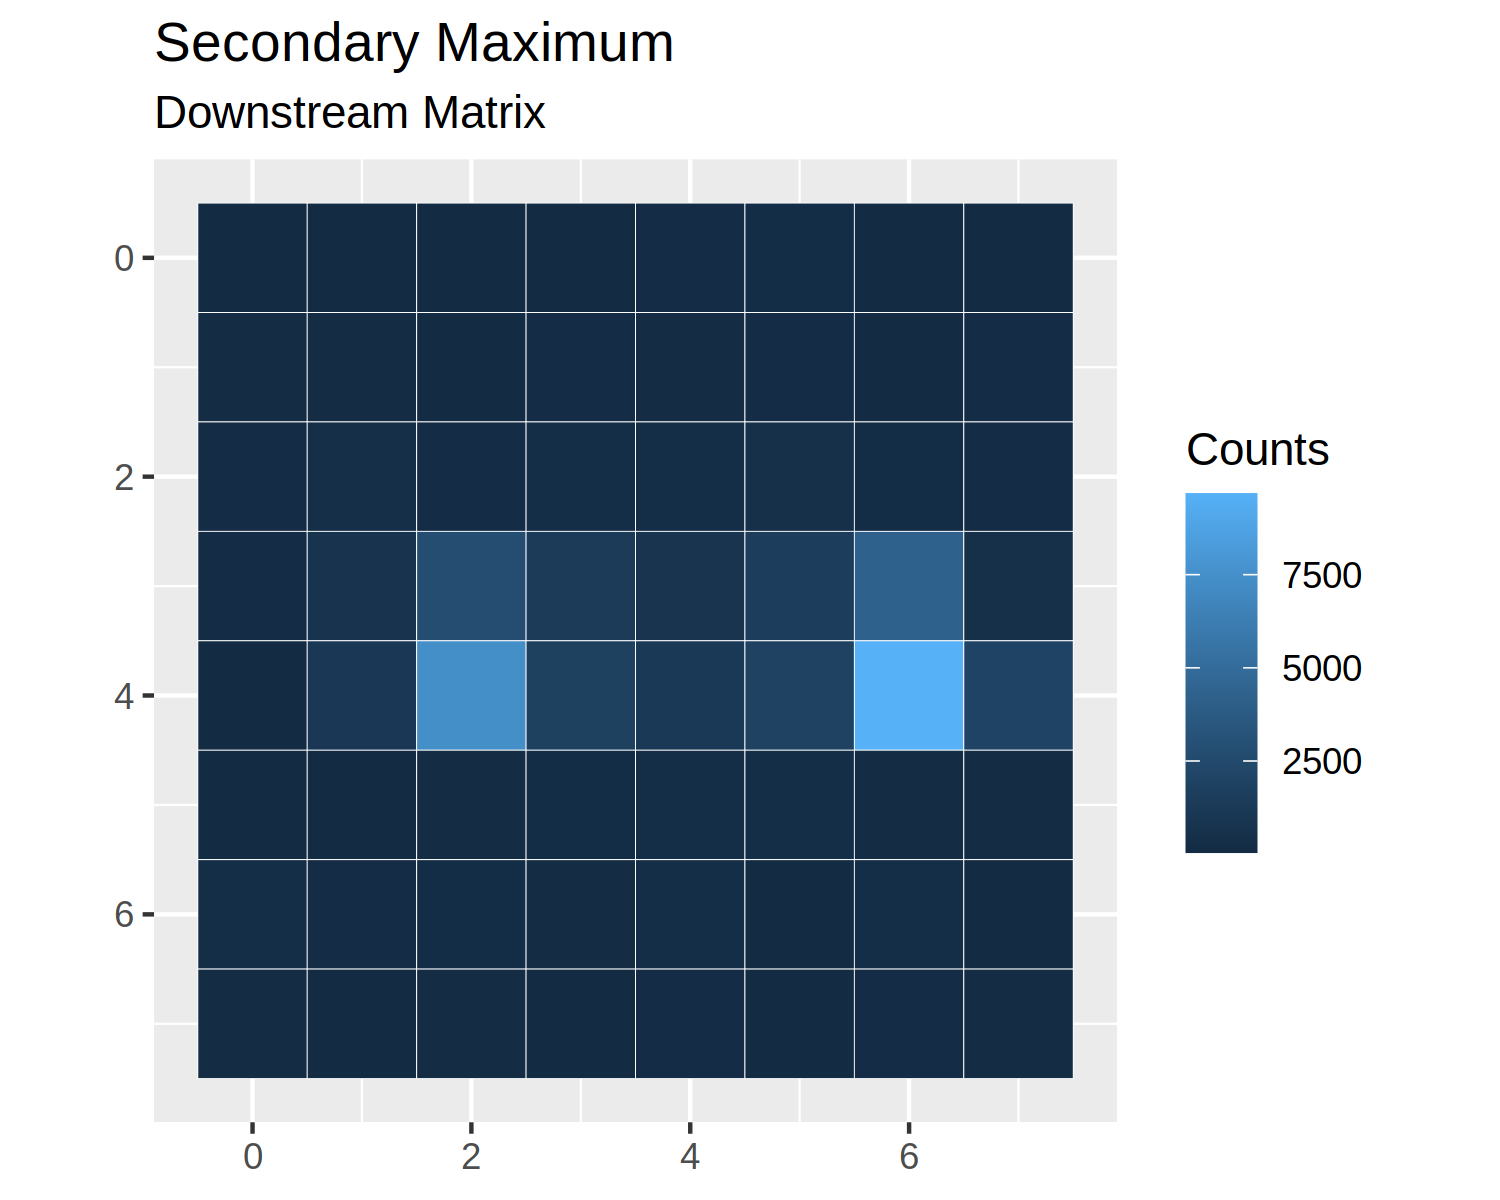

In [22]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 300)
ggplot(data=(less.lay.1 |> group_by(row.max, col.max) |> count()), mapping=aes(x=col.max, y=row.max, fill=n)) + geom_tile(color='white') + scale_y_reverse() + coord_fixed()  + labs(subtitle='Upstream Matrix', title='Primary Maximum', x=NULL, y=NULL, fill='Counts')
ggplot(data=(less.lay.1 |> group_by(row.max2, col.max2) |> count()), mapping=aes(x=col.max2, y=row.max2, fill=n)) + geom_tile(color='white') + scale_y_reverse() + coord_fixed() + labs(subtitle='Upstream Matrix', title='Secondary Maximum', x=NULL, y=NULL, fill='Counts')
ggplot(data=(less.lay.2 |> group_by(row.max, col.max) |> count()), mapping=aes(x=col.max, y=row.max, fill=n)) + geom_tile(color='white') + scale_y_reverse() + coord_fixed() + labs(subtitle='Downstream Matrix', title='Primary Maximum', x=NULL, y=NULL, fill='Counts')
ggplot(data=(less.lay.2 |> group_by(row.max2, col.max2) |> count()), mapping=aes(x=col.max2, y=row.max2, fill=n)) + geom_tile(color='white') + scale_y_reverse() + coord_fixed() + labs(subtitle='Downstream Matrix', title='Secondary Maximum', x=NULL, y=NULL, fill='Counts')

## Maximum signal matches between Upstream and Downstream

Number of matches: 37401 

Top 4 matching indeces:

idx.up,n
<dbl>,<int>
36,10297
44,6872
28,6694
35,4735


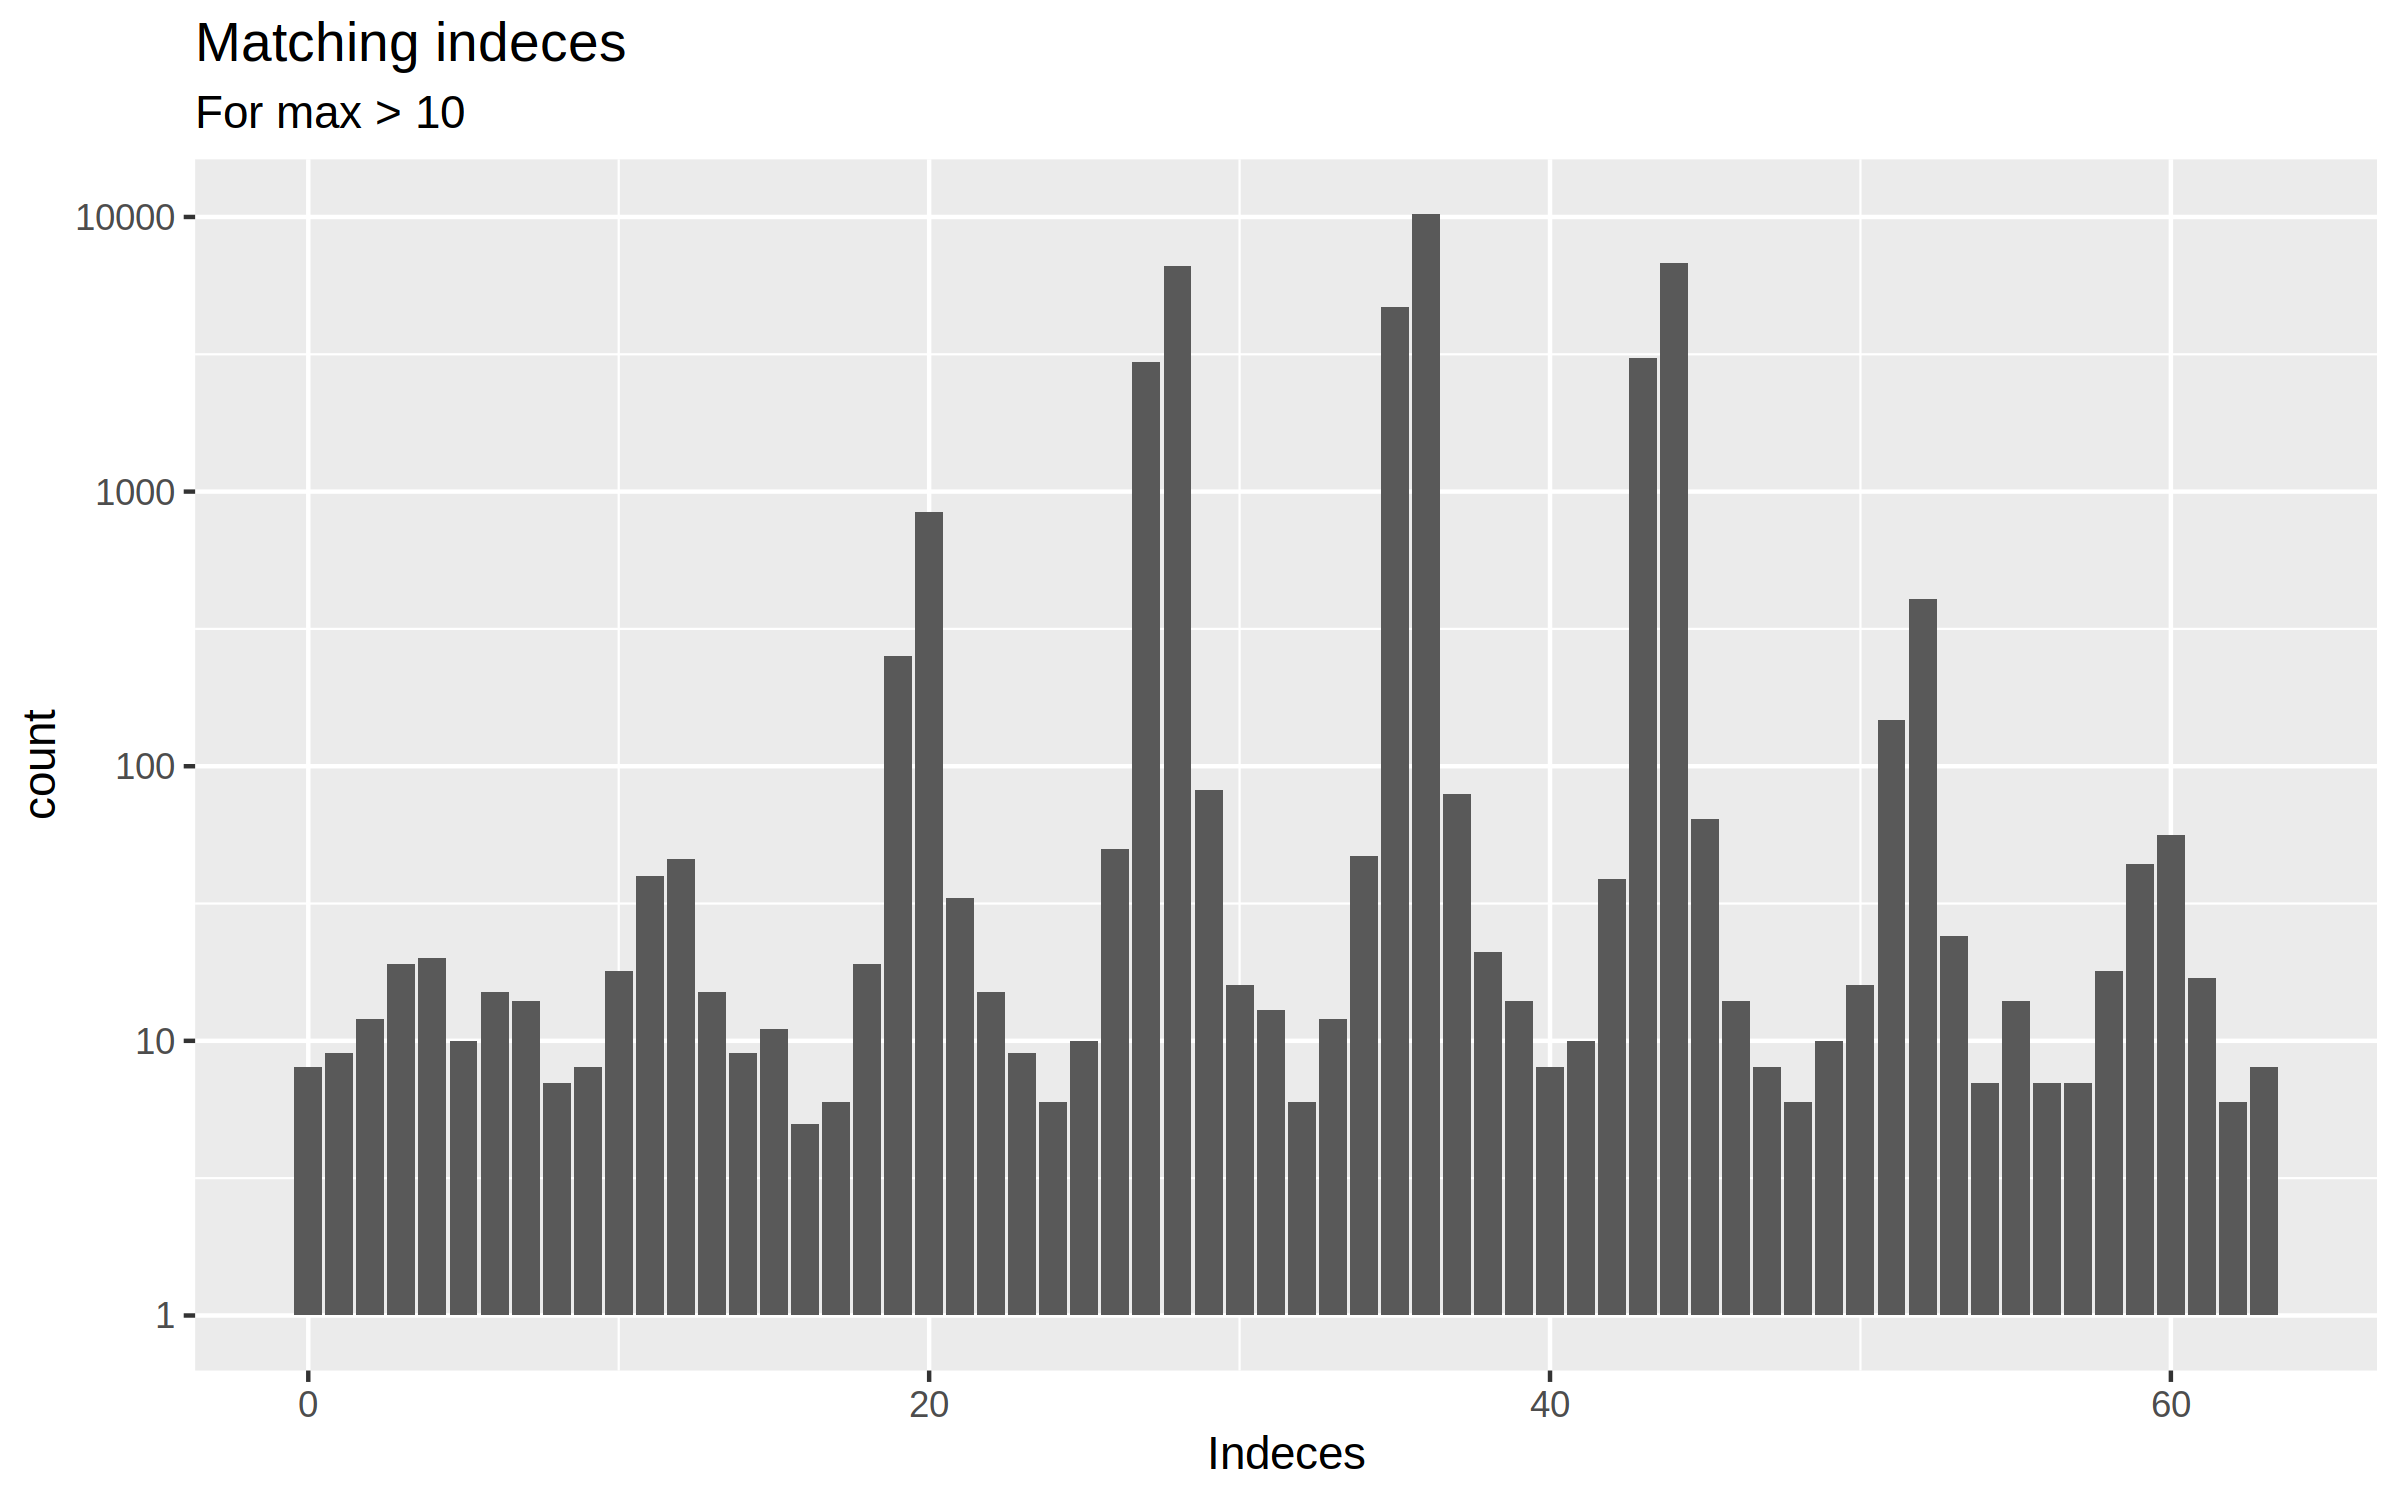

In [23]:
entwine <- tibble(max.up=lay.1$max, max.down=lay.2$max, idx.up=lay.1$px.idx.max, idx.down=lay.2$px.idx.max)
less.same <- (same.idx <- entwine |> filter(idx.up==idx.down)) |> filter(max.up > 10 | max.down > 10)

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 300)
ggplot(less.same, aes(idx.up)) + geom_bar() + scale_y_log10() + labs(title='Matching indeces', subtitle='For max > 10', x='Indeces')

# The following are calculated over all the matches as it is not specified whether to exclude those with max > 10
cat('Number of matches:', (same.idx |> count())[[1]], '\n\nTop 4 matching indeces:')
(same.idx |> group_by(idx.up) |> count() |> arrange(desc(n)))[1:4,]